<a href="https://colab.research.google.com/github/nando-cezar/pandora/blob/developer/pandora_analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PANDORA: Statistical model for predicting climate disasters


# Introduction

> EM-DAT will be used, which is a global database that records information about natural and technological disasters. It is maintained by the Disaster Epidemiology Research Center (CRED) at the Catholic University of Louvain, Belgium. EM-DAT provides data on the occurrence, impact and response to disasters since the beginning of the 20th century.

> Data analysis will be separated by category, namely:

*   Riverine flood
*   Cold wave
*   Flash flood
*   Tropical cyclone
*   Heat wave
*   Storm, General
*   Flood, General







# Importing libraries


In [1]:
!pip install folium
!pip3 install opencage
!pip install openmeteo-requests
!pip install requests-cache retry-requests numpy pandas
!pip install firebase-admin

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.5 MB/s eta 0:00:00


In [2]:
import warnings

import numpy as np
import pandas as pd
from google.colab import drive
from google.colab import userdata

import requests_cache
from retry_requests import retry

import seaborn as sns
import matplotlib.pyplot as plt

import folium

from opencage.geocoder import OpenCageGeocode
import openmeteo_requests

from string import ascii_letters

from scipy.stats import ttest_rel
from scipy.stats import pearsonr, spearmanr, kendalltau

import firebase_admin
from firebase_admin import credentials


warnings.simplefilter("ignore")
drive.mount('/content/drive')

Mounted at /content/drive


# General functions


> Algorithm for processing data (Formatting date for the api model)



In [3]:
def date_format_API(date):
    # Joining the elements of the 'date' iterable using hyphens ('-')
    return "-".join([
        # If the item is a float, convert it to an integer, then to a string and pad with zeros if necessary
        str(int(item)).zfill(2) if isinstance(item, float)
        # Otherwise, convert the item to a string and pad with zeros if necessary
        else str(item).zfill(2)
        # Iterating over each item in the 'date' iterable
        for item in date
    ])

> Algorithm for boxplot graph plating

In [4]:
def generate_bsplot(dataFrame, xv, yv, xlabel, ylabel, title, width=25, height=10, boxplot_width=0.5):
    # Create a new figure with specified width and height
    plt.figure(figsize=(width, height))

    # Create a boxplot based on the provided DataFrame, x and y variables
    sns.boxplot(
        data=dataFrame,
        x=xv,
        y=yv
    )

    # Create a stripplot based on the provided DataFrame, x and y variables
    sns.stripplot(
        data=dataFrame,
        x=xv,
        y=yv
    )

    # Set the label for x-axis
    plt.xlabel(xlabel)

    # Set the label for y-axis
    plt.ylabel(ylabel)

    # Set the title of the plot
    plt.title(title)

    # Enable grid on the plot
    plt.grid(True)

    # Display the plot
    plt.show()

> Algorithm for boxplot graph heatmap

In [5]:
def generate_heatmap(dataFrame, disaster_subtype, width=13, height=8):
    # Filter the DataFrame based on the provided disaster subtype and calculate the correlation matrix
    corr = dataFrame.query(f'disaster_subtype == "{disaster_subtype}"').corr().fillna(0)

    # Create a new figure with specified width and height
    f, ax = plt.subplots(figsize=(width, height))

    # Create a heatmap of the correlation matrix with specified colormap, square cells, and annotations
    sns.heatmap(
        corr,
        cmap="YlGnBu",
        square=True,
        annot=True
    )

    # Return the correlation matrix
    return corr

> Algorithm for barplot

In [6]:
def generate_barplot(xv, yv, width=13, height=8):

    plt.figure(figsize=(width, height))
    sns.barplot(x=xv, y=yv, palette='viridis')
    plt.title('Percentage Similarity between Forecast Correlation and Disaster Subtype Correlation')
    plt.xlabel('Disaster Subtype')
    plt.ylabel('Percentage Similarity')
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 100)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

> Algorithm for switch value

In [7]:
def switch_value(source, offset, target):
    # If source equals offset, return the target value; otherwise, return the source value
    return target if source == offset else source

> Algorithm for get max index

In [8]:
def get_max_index(data, target):

    max_value = -1
    max_index = -1

    for index, item in enumerate(data):
        value = item.get(target, 0)
        if value > max_value:
            max_value = value
            max_index = index

    return max_index

> Dictionary for color storage

In [9]:
# Dictionary containing mapping of disaster types to colors
dic_colors = {
    'Riverine flood': 'red',
    'Cold wave': 'blue',
    'Flash flood': 'green',
    'Tropical cyclone': 'orange',
    'Heat wave': 'lightblue',
    'Storm, General': 'darkblue',
    'Flood, General': 'black',
}

# Function to get color based on the disaster type
def get_color(key):
    # Return the color corresponding to the given key from the dictionary
    return dic_colors[key]

Dictionary for disaster subtype

In [10]:
# Dictionary containing mapping of disaster subtypes to their respective codes
dic_disaster_subtype_code = {
    'Riverine flood': 0,
    'Cold wave': 1,
    'Flash flood': 2,
    'Tropical cyclone': 3,
    'Heat wave': 4,
    'Storm, General': 5,
    'Flood, General': 6,
}

# Function to get the code for a given disaster subtype
def get_disaster_subtype_code(key):
    # Return the code corresponding to the given disaster subtype key from the dictionary
    return dic_disaster_subtype_code[key]

Algorithm for obtain correlation between variables

In [11]:
def get_correlation_variables(dataFrame, disaster_subtype, offset=0.9):
    # Calculate the correlation matrix for the specified disaster subtype and find correlations higher than the offset
    high_correlation = dataFrame.query(f'disaster_subtype == "{disaster_subtype}"').corr().abs() > offset

    # Unstack the correlation matrix to create pairs of correlated variables
    variable_pairs = high_correlation.unstack()

    # Filter to keep only the pairs with correlation higher than the offset
    variable_pairs = variable_pairs[variable_pairs]

    # Print the pairs of correlated variables
    print(variable_pairs)

# EM-DAT


##Reading the file

> Restricting reading to the following columns: location, start date and end date.

In [12]:
# Read an Excel file into a Pandas DataFrame
# The file path is constructed dynamically using userdata dictionary
# The sheet_name parameter specifies the sheet to read, using index 0 and the sheet name "EM-DAT Data"
# usecols parameter specifies which columns to read from the Excel file
df = pd.read_excel(
    f"{userdata.get('notebook_path')}/{userdata.get('file_path')}.xlsx",  # File path constructed using userdata
    sheet_name=[0, "EM-DAT Data"],  # Read from index 0 and sheet named "EM-DAT Data"
    usecols='A, G, K, N, Z, AA, AB, AC, AD, AE'  # Read specific columns
)

##File handling


> Performing row removal with NaN

In [13]:
# Dictionary specifying the data type for each column
_data_type = {
    'DisNo.': str,             # Disaster number as string
    'Disaster_Subtype': str,   # Disaster subtype as string
    'Country': str,            # Country name as string
    'Location': str,           # Location as string
    'Start_Year': int,         # Start year as integer
    'Start_Month': int,        # Start month as integer
    'Start_Day': int,          # Start day as integer
    'End_Year': int,           # End year as integer
    'End_Month': int,          # End month as integer
    'End_Day': int             # End day as integer
}

# Fill NaN values in the 'EM-DAT Data' sheet with 0 and convert columns to specified data types
df = df['EM-DAT Data'].fillna(0).astype(_data_type)

## Data visualization without processing

In [14]:
display(df)

DisNo.  Disaster_Subtype Country  \
0   2000-0019-BRA    Riverine flood  Brazil   
1   2000-0456-BRA         Cold wave  Brazil   
2   2000-0590-BRA    Riverine flood  Brazil   
3   2000-0809-BRA    Riverine flood  Brazil   
4   2001-0213-BRA    Riverine flood  Brazil   
..            ...               ...     ...   
79  2023-0434-BRA    Flood, General  Brazil   
80  2023-0603-BRA  Tropical cyclone  Brazil   
81  2023-0663-BRA    Flood, General  Brazil   
82  2023-0747-BRA    Severe weather  Brazil   
83  2023-0777-BRA    Flood, General  Brazil   

                                             Location  Start_Year  \
0   Rio de Janeiro, Rio de Janeiro; Sao Paulo, Sao...        2000   
1                     Porto Alegre, Rio Grande Do Sul        2000   
2   Recife, Pernambuco; Jaboatao Dos Guararapes, P...        2000   
3   Belo Horizonte, Minas Gerais; Santos, Sao Paul...        2000   
4                                 Cuiaba, Mato Grosso        2001   
..                                                ...         ...   
79  Matriz de Camaragibe, Alagoas; Marechal Deodor...        2023   
80  Muçum, Rio Grande do Sul; Roca Sales, Rio Gran...        2023   
81  Rio do Sul, Santa Catarina; Tubarão, Santa Cat...        2023   
82  Porto Alegre, Rio Grande do Sul; Balneário Cam...        2023   
83  Arroio do Meio, Rio Grande do Sul; Colinas, Ri...        2023   

    Start_Month  Start_Day  End_Year  End_Month  End_Day  
0             1          1      2000          1        6  
1             7          0      2000          7        0  
2             9         16      2000          9       18  
3            12         17      2000         12       26  
4             4         25      2001          4       26  
..          ...        ...       ...        ...      ...  
79            7         10      2023          7       14  
80            9          1      2023          9        4  
81           10         10      2023         10       10  
82           11         11      2023         11       14  
83           11         13      2023         11       19  

[84 rows x 10 columns]

# OPEN CAGE GEOCODE

>Load latitude and longitude information from API

## API call


> Algorithm for processing data (Search latitude and longitude from location)

In [15]:
# Initialize the OpenCageGeocode object with the provided API key from the userdata dictionary
geocoder = OpenCageGeocode(userdata.get('api_key_opencage_geocode'))

# Function to search for location information based on the provided query
def search_location(query):
    # Use the geocoder to geocode the query
    response = geocoder.geocode(query)
    # Return the response containing location information
    return response

> Getting information and formatting dataframe


In [16]:
# Initialize an empty list to store location information
_locale_structure = []

# Function to retrieve detailed location information based on the provided location and country
def get_location_info(location, country):
    # Combine the location and country into a single query
    location_join = ", ".join([location, country])
    # Search for location information using the combined query
    result = search_location(query=location_join)

    # If location information is found, extract relevant details and return them
    if result:
        #index = get_max_index(result, "confidence")
        index = 0
        location_info = {
            'Country': result[index]["components"]["country"],
            'Continent': result[index]["components"]["continent"],
            'Formatted': result[index]["formatted"],
            'Latitude': result[index]["geometry"]["lat"],   # Latitude
            'Longitude': result[index]["geometry"]["lng"],  # Longitude
            'Timezone': result[index]["annotations"]["timezone"]["name"]  # Timezone
        }
        return location_info

    # If no location information is found, return None
    return None

# Function to process location information
def process_location_info(infos):
    # Adjust start and end day/month values if they are 0
    start_day = switch_value(infos['Start_Day'], 0, 1)
    end_day = switch_value(infos['End_Day'], 0, 30)
    start_month = switch_value(infos['Start_Month'], 0, 1)
    end_month = switch_value(infos['End_Month'], 0, 12)

    # Construct start and end dates
    start_date = [infos['Start_Year'], start_month, start_day]
    end_date = [infos['End_Year'], end_month, end_day]

    # Split location string if it contains multiple locations
    rdf = infos["Location"].split(';')

    # Process each location
    if rdf:
        for location in rdf:
            # Retrieve detailed location information
            location_info = get_location_info(location.strip(), infos["Country"])
            # If location information is found and it's not the same as the country, append it to _locale_structure
            if location_info and location_info["Formatted"] != infos["Country"]:
                location_info.update(
                    {
                        'DisNo.': infos['DisNo.'],                  # Disaster number
                        'Disaster_Subtype': infos['Disaster_Subtype'],  # Disaster subtype
                        'Start_Date': start_date,                      # Start date
                        'End_Date': end_date                          # End date
                        }
                    )
                _locale_structure.append(location_info)

# Iterate over each row in the DataFrame and process location information
for _, infos in df.iterrows():
    process_location_info(infos)

## Data visualization without processing

In [17]:
# Dictionary specifying the data type for each column in the DataFrame
_data_type = {
    'DisNo.': str,               # Disaster number as string
    'Disaster_Subtype': str,     # Disaster subtype as string
    'Country': str,
    'Continent': str,
    'Formatted': str,
    'Latitude': str,             # Latitude as string
    'Longitude': str,            # Longitude as string
    'Start_Date': object,        # Start date as object (will be parsed)
    'End_Date': object,          # End date as object (will be parsed)
    'Timezone': object
}

# Create a DataFrame from the _locale_structure list and convert columns to specified data types
df = pd.DataFrame(_locale_structure).astype(_data_type)

# Display the DataFrame
display(df)

Country      Continent                                          Formatted  \
0    Brazil  South America  Rio de Janeiro, Região Metropolitana do Rio de...   
1    Brazil  South America  São Paulo, Região Metropolitana de São Paulo, ...   
2    Brazil  South America  Campos do Jordão, Região Metropolitana do Vale...   
3    Brazil  South America  Volta Redonda, Região Geográfica Intermediária...   
4    Brazil  South America  Barra Mansa, Região Geográfica Intermediária d...   
..      ...            ...                                                ...   
380  Brazil  South America  Lajeado, Região Geográfica Intermediária de Sa...   
381  Brazil  South America  Muçum, Região Geográfica Intermediária de Sant...   
382  Brazil  South America  Roca Sales, Região Geográfica Intermediária de...   
383  Brazil  South America  Santa Tereza, Região Geográfica Intermediária ...   
384  Brazil  South America  Taquari, Região Geográfica Intermediária de Sa...   

        Latitude    Longitude           Timezone         DisNo.  \
0    -22.9110137  -43.2093727  America/Sao_Paulo  2000-0019-BRA   
1    -23.5506507  -46.6333824  America/Sao_Paulo  2000-0019-BRA   
2     -22.738299  -45.5903769  America/Sao_Paulo  2000-0019-BRA   
3     -22.521856  -44.1040128  America/Sao_Paulo  2000-0019-BRA   
4    -22.5394843  -44.1735129  America/Sao_Paulo  2000-0019-BRA   
..           ...          ...                ...            ...   
380  -29.4671522  -51.9624046  America/Sao_Paulo  2023-0777-BRA   
381  -29.1666714  -51.8747726  America/Sao_Paulo  2023-0777-BRA   
382  -29.2872555  -51.8724318  America/Sao_Paulo  2023-0777-BRA   
383  -29.1697808  -51.7363155  America/Sao_Paulo  2023-0777-BRA   
384    -29.79433   -51.865346  America/Sao_Paulo  2023-0777-BRA   

    Disaster_Subtype      Start_Date        End_Date  
0     Riverine flood    [2000, 1, 1]    [2000, 1, 6]  
1     Riverine flood    [2000, 1, 1]    [2000, 1, 6]  
2     Riverine flood    [2000, 1, 1]    [2000, 1, 6]  
3     Riverine flood    [2000, 1, 1]    [2000, 1, 6]  
4     Riverine flood    [2000, 1, 1]    [2000, 1, 6]  
..               ...             ...             ...  
380   Flood, General  [2023, 11, 13]  [2023, 11, 19]  
381   Flood, General  [2023, 11, 13]  [2023, 11, 19]  
382   Flood, General  [2023, 11, 13]  [2023, 11, 19]  
383   Flood, General  [2023, 11, 13]  [2023, 11, 19]  
384   Flood, General  [2023, 11, 13]  [2023, 11, 19]  

[385 rows x 10 columns]

#OPEN-METEO - Historical Weather API



> Load weather information from API

## API call

> Algorithm for processing data (Search weather from latitude and longitude)


In [18]:
# Setup the Open-Meteo API client with cache and retry on error
# Cache session to store API responses locally
cache_session = requests_cache.CachedSession('.cache', expire_after=-1)
# Retry session to automatically retry requests in case of errors
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
# Create Open-Meteo API client with the retry session
openmeteo = openmeteo_requests.Client(session=retry_session)

# Function to search for weather information using Open-Meteo API
def search_info_weather(id, disaster_subtype, country, continent, formatted, latitude, longitude, start_date, end_date, timezone):

    # Format start and end dates for API request
    start_date = date_format_API(date=start_date)
    end_date = date_format_API(date=end_date)

    # Define parameters for API request
    params = {
        "latitude": latitude,
        "longitude": longitude,
        "start_date": start_date,
        "end_date": end_date,
        "daily": [
            "temperature_2m_max",
            "temperature_2m_min",
            "apparent_temperature_max",
            "apparent_temperature_min",
            "precipitation_sum",
            "rain_sum",
            "snowfall_sum",
            "precipitation_hours",
            "wind_speed_10m_max",
            "wind_gusts_10m_max",
            "wind_direction_10m_dominant",
            "shortwave_radiation_sum",
            "et0_fao_evapotranspiration"
        ],
        "timezone": timezone,
        "models": [
            "best_match"
        ]
    }

    # Call Open-Meteo API to retrieve weather data
    responses = openmeteo.weather_api(userdata.get('api_url_openmeteo_historical'), params=params)

    # Process first location. Add a for-loop for multiple locations or weather models
    response = responses[0]

    # Process daily weather data
    daily = response.Daily()
    variables = [daily.Variables(i).ValuesAsNumpy() for i in range(13)]
    variable_names = [
        "temperature_2m_max",
        "temperature_2m_min",
        "apparent_temperature_max",
        "apparent_temperature_min",
        "precipitation_sum",
        "rain_sum",
        "snowfall_sum",
        "precipitation_hours",
        "wind_speed_10m_max",
        "wind_gusts_10m_max",
        "wind_direction_10m_dominant",
        "shortwave_radiation_sum",
        "et0_fao_evapotranspiration"
    ]

    # Create dictionary to store daily weather data
    daily_data = {"date": pd.date_range(
        start=pd.to_datetime(daily.Time(), unit="s"),
        end=pd.to_datetime(daily.TimeEnd(), unit="s"),
        freq=pd.Timedelta(seconds=daily.Interval()),
        inclusive="left"
    )}

    # Populate daily data dictionary with weather information
    daily_data["id"] = id
    daily_data["disaster_subtype_code"] = get_disaster_subtype_code(disaster_subtype)
    daily_data["disaster_subtype"] = disaster_subtype.replace("/", ", ")
    daily_data["country"] = country
    daily_data["continent"] = continent
    daily_data["formatted"] = formatted
    daily_data["latitude"] = response.Latitude()
    daily_data["longitude"] = response.Longitude()

    # Add weather variables to daily data dictionary
    for name, values in zip(variable_names, variables):
        daily_data[name] = values

    return daily_data


> Getting information and formatting dataframe

In [19]:
# Initialize an empty list to store weather information
_weather_structure = []

# Iterate over each row in the DataFrame and retrieve weather information
for i, infos in df.query('Disaster_Subtype != "Mudslide" and Disaster_Subtype != "Drought" and Disaster_Subtype != "Severe weather" and Disaster_Subtype != "Landslide, wet" and Disaster_Subtype != "Tornado" and Disaster_Subtype != "Lightning/Thunderstorms"').iterrows():
    # Call the search_info_weather function to retrieve weather information
    _info = search_info_weather(
        id=infos['DisNo.'],                         # Disaster number
        disaster_subtype=infos['Disaster_Subtype'], # Disaster subtype
        country=infos['Country'],
        continent=infos['Continent'],
        formatted=infos['Formatted'],
        latitude=infos['Latitude'],                 # Latitude
        longitude=infos['Longitude'],               # Longitude
        start_date=infos['Start_Date'],             # Start date
        end_date=infos['End_Date'],                 # End date
        timezone=infos['Timezone']                  # Timezone
    )
    # Append the retrieved weather information to the _weather_structure list
    _weather_structure.append(_info)

##Data visualization without processing

In [20]:
df = pd.DataFrame(data = _weather_structure)
display(df)

date             id  \
0    DatetimeIndex(['2000-01-01 03:00:00', '2000-01...  2000-0019-BRA   
1    DatetimeIndex(['2000-01-01 03:00:00', '2000-01...  2000-0019-BRA   
2    DatetimeIndex(['2000-01-01 03:00:00', '2000-01...  2000-0019-BRA   
3    DatetimeIndex(['2000-01-01 03:00:00', '2000-01...  2000-0019-BRA   
4    DatetimeIndex(['2000-01-01 03:00:00', '2000-01...  2000-0019-BRA   
..                                                 ...            ...   
356  DatetimeIndex(['2023-11-13 03:00:00', '2023-11...  2023-0777-BRA   
357  DatetimeIndex(['2023-11-13 03:00:00', '2023-11...  2023-0777-BRA   
358  DatetimeIndex(['2023-11-13 03:00:00', '2023-11...  2023-0777-BRA   
359  DatetimeIndex(['2023-11-13 03:00:00', '2023-11...  2023-0777-BRA   
360  DatetimeIndex(['2023-11-13 03:00:00', '2023-11...  2023-0777-BRA   

     disaster_subtype_code disaster_subtype country      continent  \
0                        0   Riverine flood  Brazil  South America   
1                        0   Riverine flood  Brazil  South America   
2                        0   Riverine flood  Brazil  South America   
3                        0   Riverine flood  Brazil  South America   
4                        0   Riverine flood  Brazil  South America   
..                     ...              ...     ...            ...   
356                      6   Flood, General  Brazil  South America   
357                      6   Flood, General  Brazil  South America   
358                      6   Flood, General  Brazil  South America   
359                      6   Flood, General  Brazil  South America   
360                      6   Flood, General  Brazil  South America   

                                             formatted   latitude  longitude  \
0    Rio de Janeiro, Região Metropolitana do Rio de... -22.882250 -43.076111   
1    São Paulo, Região Metropolitana de São Paulo, ... -23.585238 -46.659637   
2    Campos do Jordão, Região Metropolitana do Vale... -22.741652 -45.515106   
3    Volta Redonda, Região Geográfica Intermediária... -22.530756 -44.066376   
4    Barra Mansa, Região Geográfica Intermediária d... -22.530756 -44.159760   
..                                                 ...        ...        ...   
356  Lajeado, Região Geográfica Intermediária de Sa... -29.490334 -51.919067   
357  Muçum, Região Geográfica Intermediária de Sant... -29.138840 -51.827576   
358  Roca Sales, Região Geográfica Intermediária de... -29.279438 -51.946991   
359  Santa Tereza, Região Geográfica Intermediária ... -29.138840 -51.827576   
360  Taquari, Região Geográfica Intermediária de Sa... -29.771530 -51.846680   

                                    temperature_2m_max  ...  \
0    [28.1365, 27.436499, 27.8365, 32.286503, 33.18...  ...   
1     [23.637, 21.337, 20.987, 23.337, 24.337, 26.337]  ...   
2    [20.005001, 18.305, 16.705, 19.555, 23.455, 23...  ...   
3    [24.918001, 25.018, 24.368, 26.268, 31.018, 30...  ...   
4    [25.199, 25.299, 24.499, 26.348999, 31.449, 31...  ...   
..                                                 ...  ...   
356  [24.0345, 26.0345, 28.484499, 25.734499, 26.13...  ...   
357  [23.995, 24.795, 29.895, 25.495, 29.095001, 24...  ...   
358  [24.033, 25.483, 30.033, 25.233, 28.383001, 24...  ...   
359  [23.839, 24.639, 29.739, 25.339, 28.939001, 24...  ...   
360  [23.115501, 26.0655, 28.2155, 25.3155, 24.8155...  ...   

                              apparent_temperature_min  \
0    [27.435997, 26.685484, 25.922243, 26.881165, 2...   
1    [20.647556, 18.85355, 18.814064, 19.851942, 20...   
2    [16.683985, 17.014887, 15.820475, 15.265488, 1...   
3    [23.728838, 23.259632, 22.954874, 23.09392, 20...   
4    [24.10817, 24.094795, 23.894573, 23.677664, 21...   
..                                                 ...   
356  [20.42508, 22.172544, 18.42926, 22.542397, 21....   
357  [23.239971, 22.947084, 19.587013, 23.751001, 2...   
358  [21.409447, 22.46112, 19.557192, 23.90368, 22....   
359  [23.005634, 22.71588, 19.3630

Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


## Reorganization of daily information structure

In [21]:
# List of columns to explode (convert list-like elements into separate rows)
columns_to_explode = [
    'date',
    'temperature_2m_max',
    'temperature_2m_min',
    'apparent_temperature_max',
    'apparent_temperature_min',
    'precipitation_sum',
    'rain_sum',
    'snowfall_sum',
    'precipitation_hours',
    'wind_speed_10m_max',
    'wind_gusts_10m_max',
    'wind_direction_10m_dominant',
    'shortwave_radiation_sum',
    'et0_fao_evapotranspiration'
]

# Explode specified columns in the DataFrame
df = df.explode(columns_to_explode)



##Data visualization daily information

In [22]:
# Dictionary specifying the data type for each column in the DataFrame
_data_type = {
    'date': object,                                   # Date as object
    'id': str,                                        # ID as string
    'disaster_subtype_code': int,                    # Disaster subtype code as integer
    'disaster_subtype': str,                         # Disaster subtype as string
    'country': str,
    'continent': str,
    'formatted': str,
    'latitude': str,                                 # Latitude as string
    'longitude': str,                                # Longitude as string
    'temperature_2m_max': float,                     # Maximum temperature at 2m as float
    'temperature_2m_min': float,                     # Minimum temperature at 2m as float
    'apparent_temperature_max': float,               # Maximum apparent temperature as float
    'apparent_temperature_min': float,               # Minimum apparent temperature as float
    'precipitation_sum': float,                      # Precipitation sum as float
    'rain_sum': float,                               # Rain sum as float
    'snowfall_sum': float,                           # Snowfall sum as float
    'precipitation_hours': float,                    # Precipitation hours as float
    'wind_speed_10m_max': float,                     # Maximum wind speed at 10m as float
    'wind_gusts_10m_max': float,                     # Maximum wind gusts at 10m as float
    'wind_direction_10m_dominant': float,            # Dominant wind direction at 10m as float
    'shortwave_radiation_sum': float,                # Shortwave radiation sum as float
    'et0_fao_evapotranspiration': float              # FAO evapotranspiration as float
}

# Convert DataFrame columns to specified data types
df = df.astype(_data_type)

# Display the DataFrame
display(df)

date             id  disaster_subtype_code  \
0    2000-01-01 03:00:00  2000-0019-BRA                      0   
0    2000-01-02 03:00:00  2000-0019-BRA                      0   
0    2000-01-03 03:00:00  2000-0019-BRA                      0   
0    2000-01-04 03:00:00  2000-0019-BRA                      0   
0    2000-01-05 03:00:00  2000-0019-BRA                      0   
..                   ...            ...                    ...   
360  2023-11-15 03:00:00  2023-0777-BRA                      6   
360  2023-11-16 03:00:00  2023-0777-BRA                      6   
360  2023-11-17 03:00:00  2023-0777-BRA                      6   
360  2023-11-18 03:00:00  2023-0777-BRA                      6   
360  2023-11-19 03:00:00  2023-0777-BRA                      6   

    disaster_subtype country      continent  \
0     Riverine flood  Brazil  South America   
0     Riverine flood  Brazil  South America   
0     Riverine flood  Brazil  South America   
0     Riverine flood  Brazil  South America   
0     Riverine flood  Brazil  South America   
..               ...     ...            ...   
360   Flood, General  Brazil  South America   
360   Flood, General  Brazil  South America   
360   Flood, General  Brazil  South America   
360   Flood, General  Brazil  South America   
360   Flood, General  Brazil  South America   

                                             formatted             latitude  \
0    Rio de Janeiro, Região Metropolitana do Rio de...   -22.88224983215332   
0    Rio de Janeiro, Região Metropolitana do Rio de...   -22.88224983215332   
0    Rio de Janeiro, Região Metropolitana do Rio de...   -22.88224983215332   
0    Rio de Janeiro, Região Metropolitana do Rio de...   -22.88224983215332   
0    Rio de Janeiro, Região Metropolitana do Rio de...   -22.88224983215332   
..                                                 ...                  ...   
360  Taquari, Região Geográfica Intermediária de Sa...  -29.771530151367188   
360  Taquari, Região Geográfica Intermediária de Sa...  -29.771530151367188   
360  Taquari, Região Geográfica Intermediária de Sa...  -29.771530151367188   
360  Taquari, Região Geográfica Intermediária de Sa...  -29.771530151367188   
360  Taquari, Região Geográfica Intermediária de Sa...  -29.771530151367188   

              longitude  temperature_2m_max  ...  apparent_temperature_min  \
0    -43.07611083984375           28.136499  ...                 27.435997   
0    -43.07611083984375           27.436499  ...                 26.685484   
0    -43.07611083984375           27.836500  ...                 25.922243   
0    -43.07611083984375           32.286503  ...                 26.881165   
0    -43.07611083984375           33.186501  ...                 26.335186   
..                  ...                 ...  ...                       ...   
360      -51.8466796875           28.215500  ...                 18.984413   
360      -51.8466796875           25.315500  ...                 22.832615   
360      -51.8466796875           24.815500  ...                 18.749744   
360      -51.8466796875           25.165501  ...                 20.004423   
360      -51.8466796875           25.265501  ...                 16.594753   

     precipitation_sum   rain_sum  snowfall_sum  precipitation_hours  \
0            15.400001  15.400001           0.0                 17.0   
0            69.500000  69.500000           0.0                 22.0   
0            28.199997  28.199997           0.0                 18.0   
0             0.000000   0.000000           0.0                  0.0   
0             0.100000   0.100000           0.0                  1.0   
..                 ...        ...           ...                  ...   
360          29.100002  29.100002           0.0                 10.0   
360           8.200000   8.200000           0.0                 12.0   
360          66.599991  66.599991           0.0                 12.0   
360          16.400000  16.400000           0.0         

# World Map


> Viewing locations

In [23]:
# Initialize a Folium map centered at the specified latitude and longitude
m = folium.Map([-15.7215815, -48.0197578])

# Extract relevant columns from the DataFrame and drop duplicate rows
df_ = df[['latitude', 'longitude', 'disaster_subtype', 'id']].drop_duplicates()

print(len(df_))
# Iterate over each row in the DataFrame and add markers to the Folium map
for i, infos in df_.iterrows():
    # Create a marker at the specified location with tooltip and popup information
    folium.Marker(
        location=[infos["latitude"], infos["longitude"]],     # Marker location
        tooltip=infos["disaster_subtype"],                    # Tooltip showing disaster subtype
        popup=infos["id"],                                    # Popup showing disaster ID
        icon=folium.Icon(color=get_color(key=infos["disaster_subtype"])),  # Marker color based on disaster subtype
    ).add_to(m)  # Add marker to the map

# Display the Folium map
m

341


#Data analysis


### Viewing data categorized by disaster subtypes

> Temperature

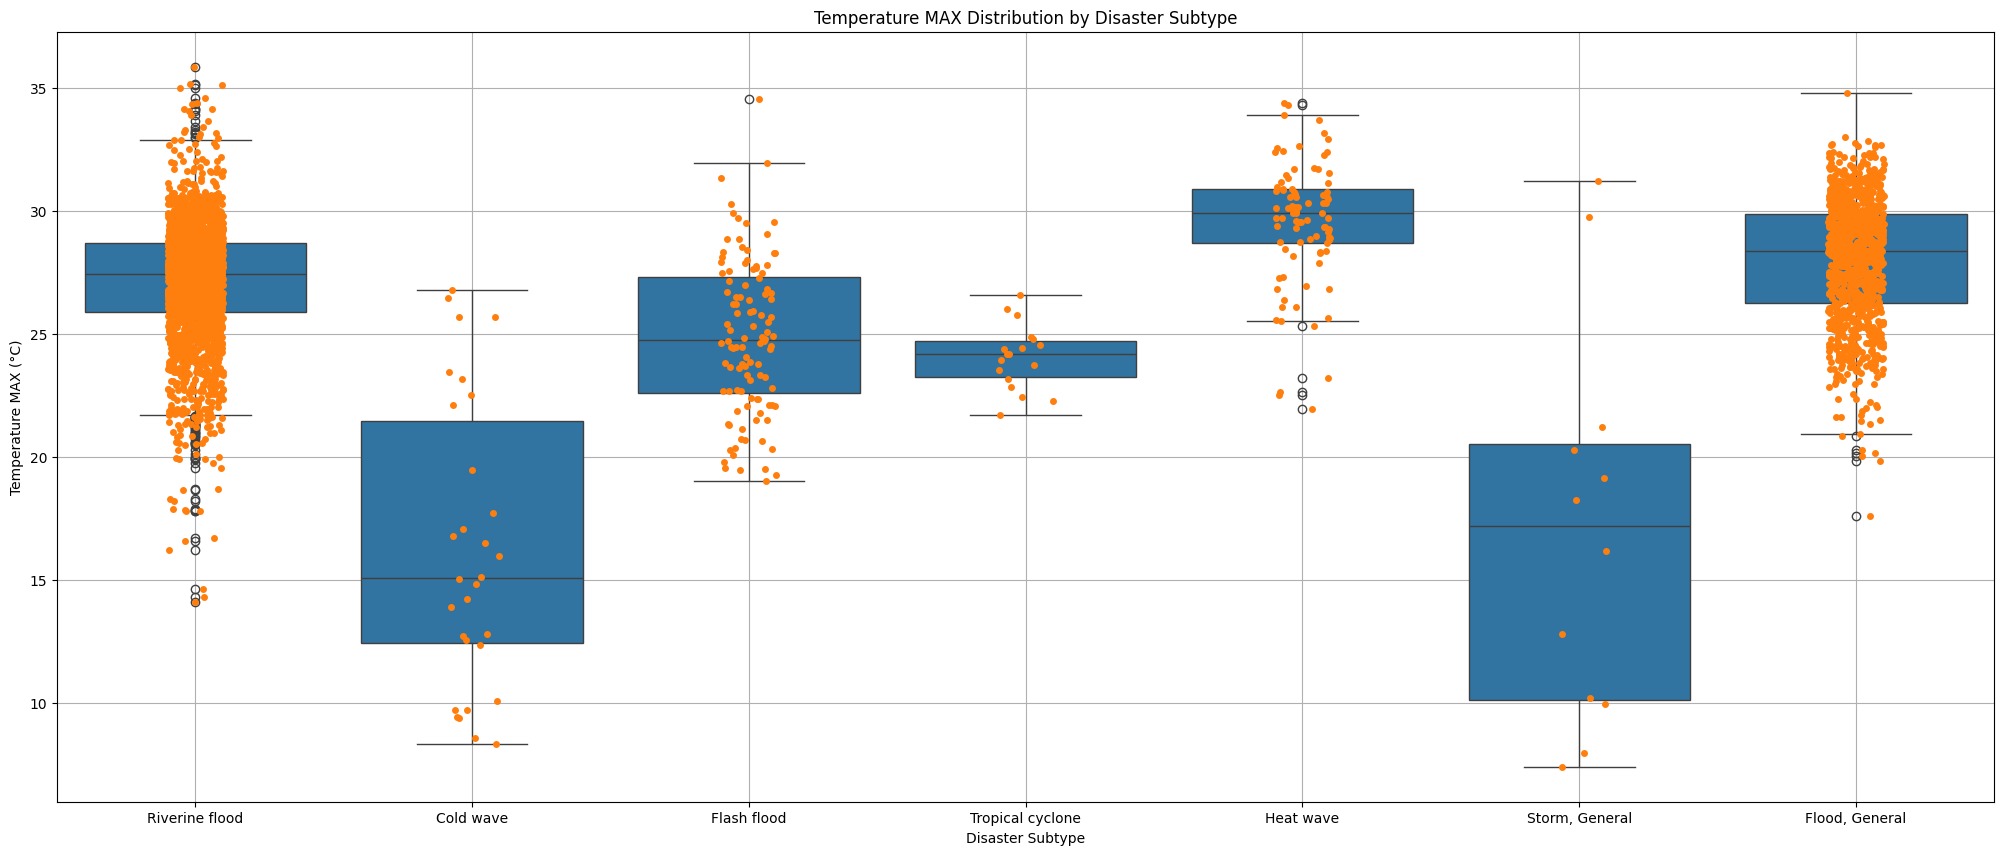

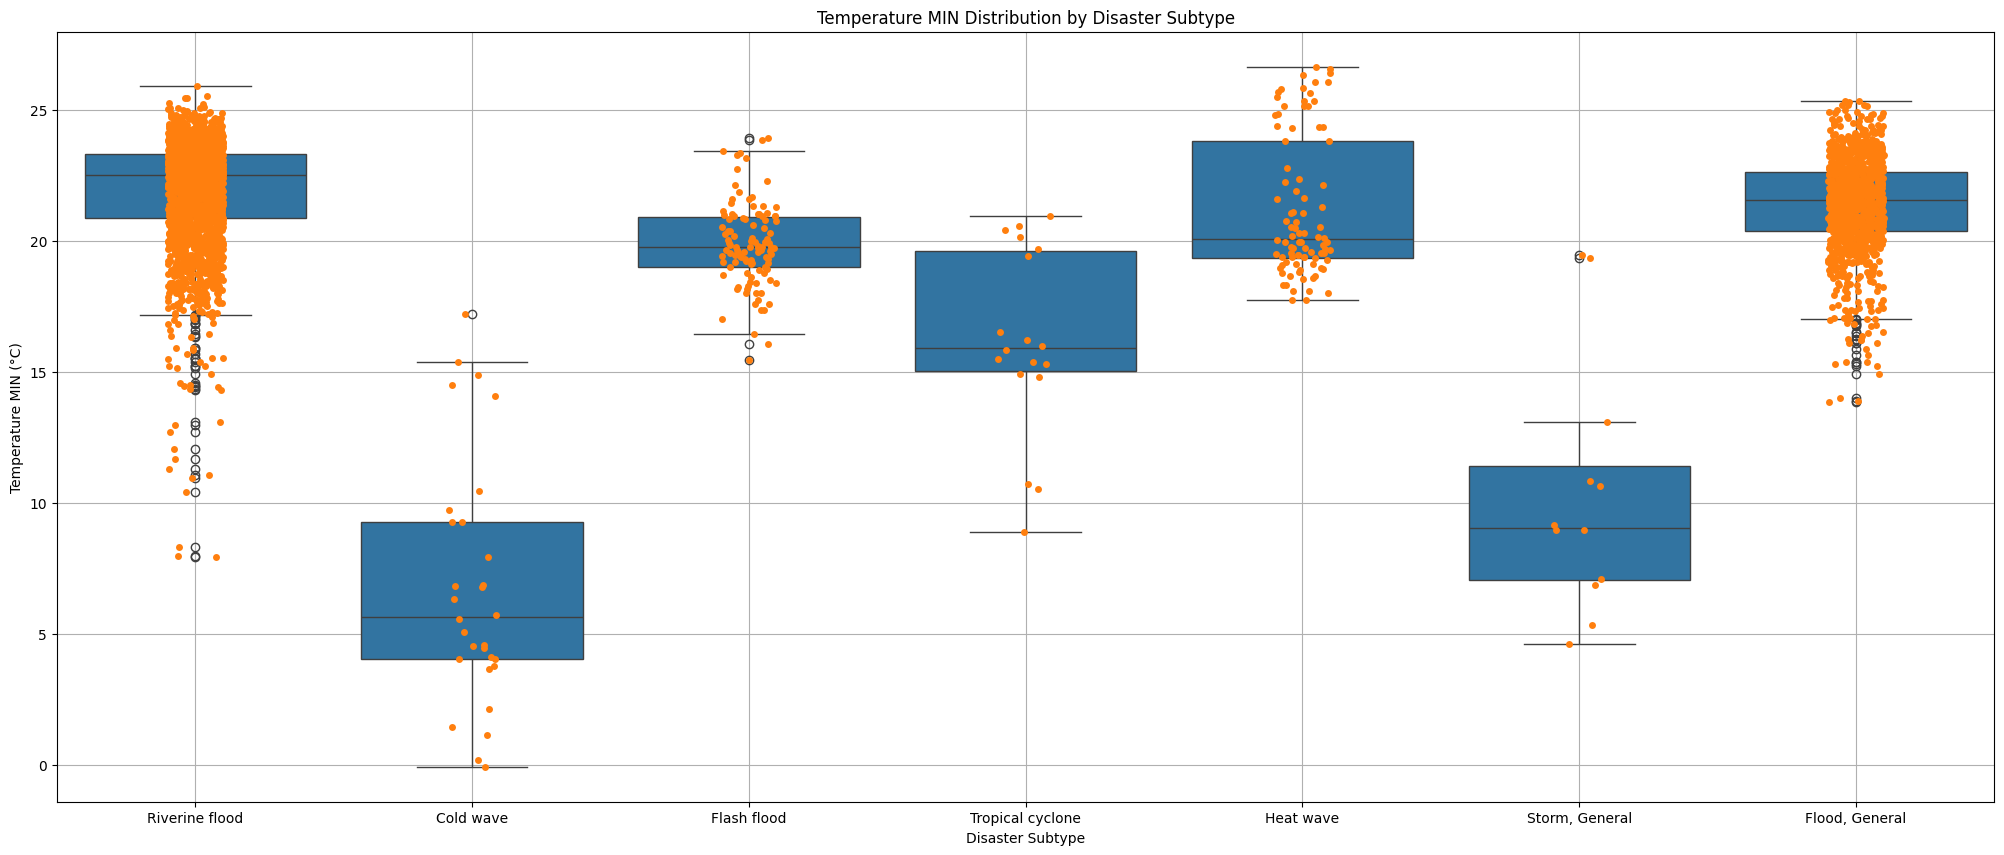

In [24]:
generate_bsplot(
    dataFrame=df,
    xv="disaster_subtype",
    yv="temperature_2m_max",
    xlabel="Disaster Subtype",
    ylabel="Temperature MAX (°C)",
    title="Temperature MAX Distribution by Disaster Subtype"
    )

generate_bsplot(
    dataFrame=df,
    xv="disaster_subtype",
    yv="temperature_2m_min",
    xlabel="Disaster Subtype",
    ylabel="Temperature MIN (°C)",
    title="Temperature MIN Distribution by Disaster Subtype"
    )

> Apparent Temperature

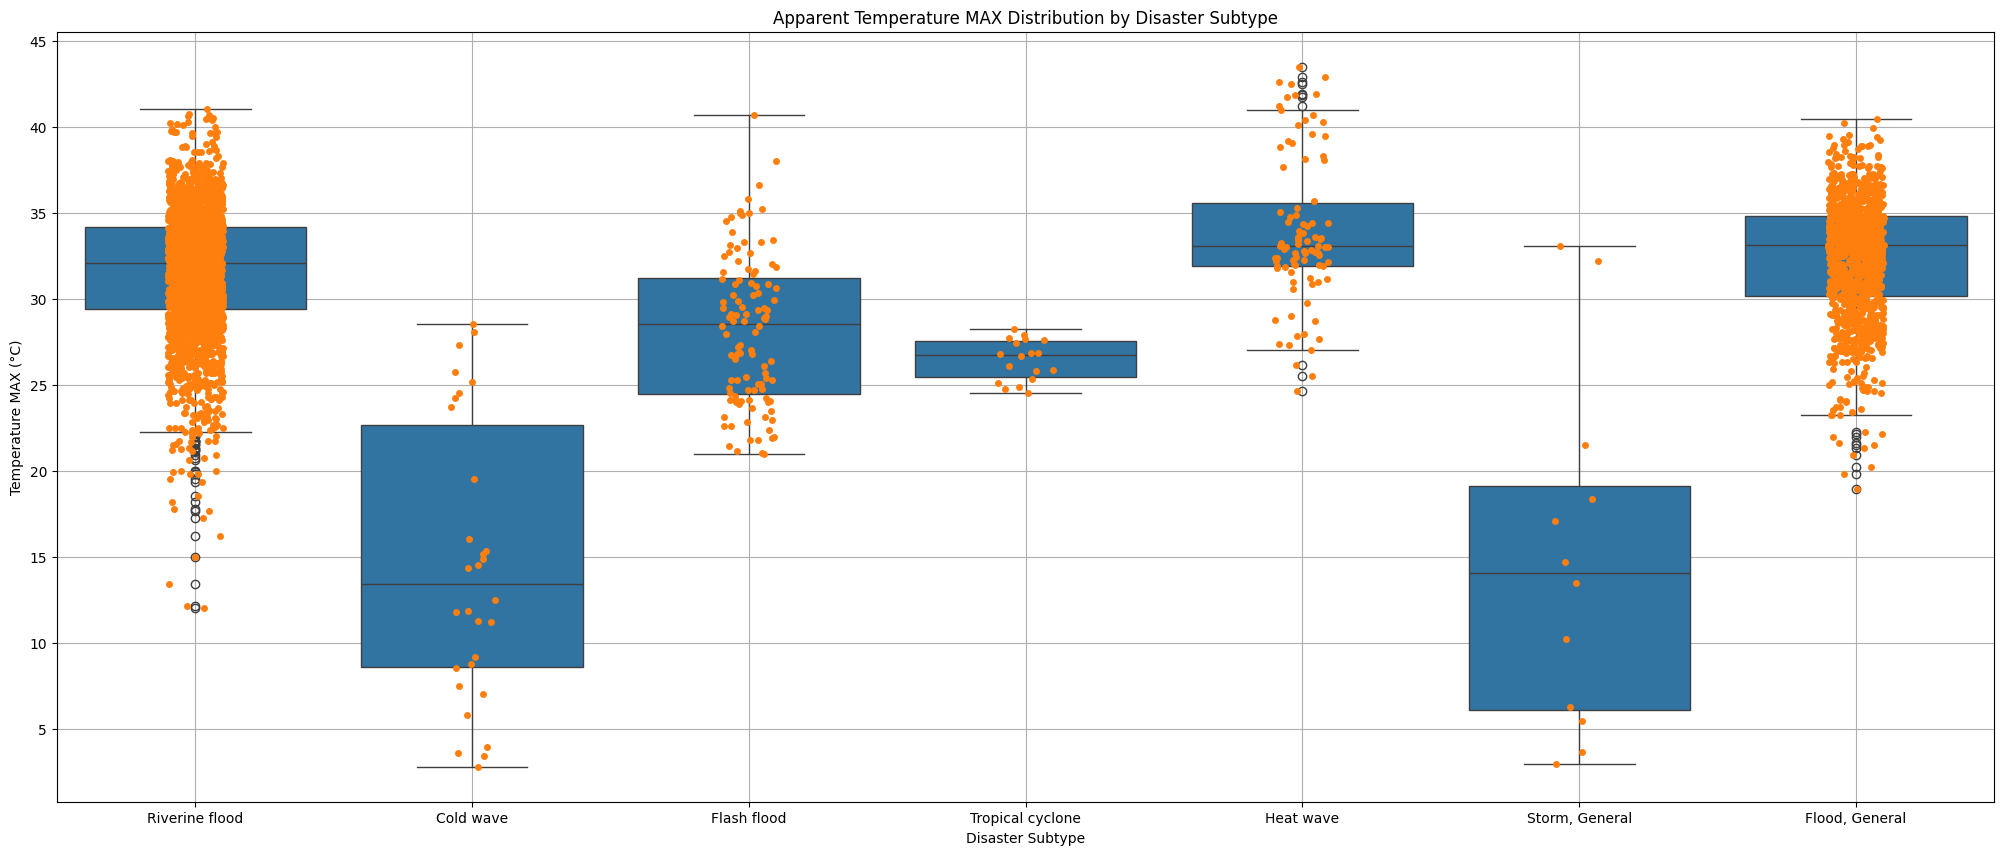

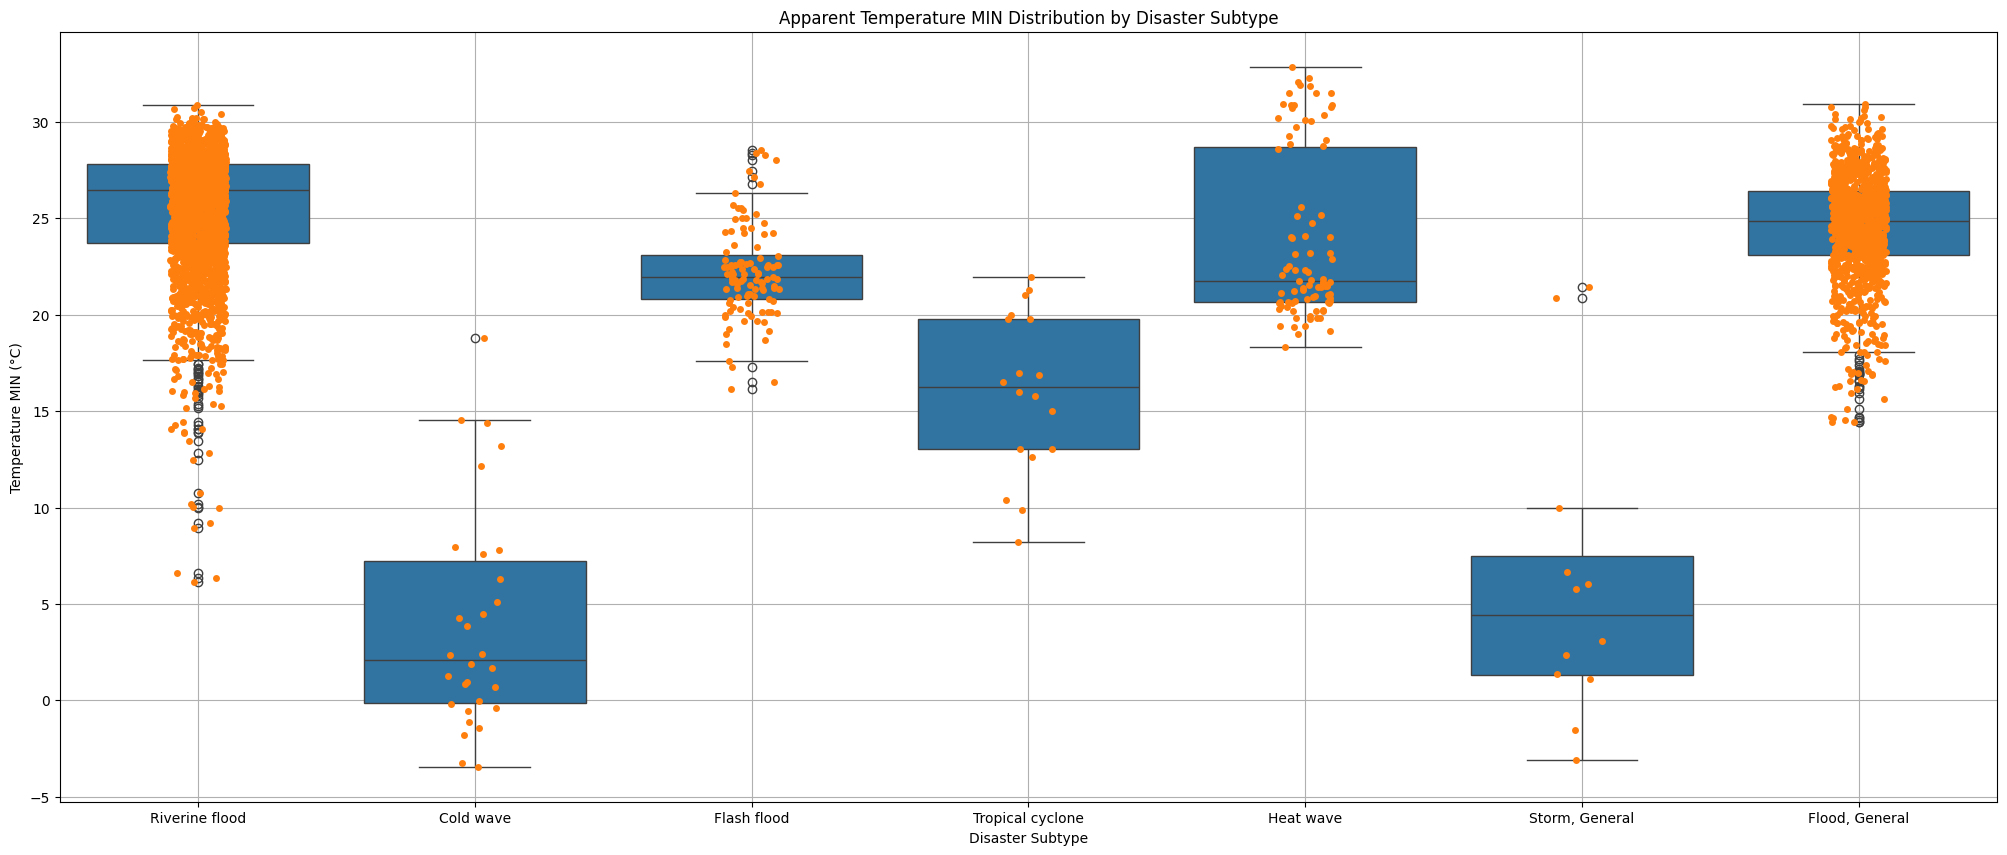

In [25]:
generate_bsplot(
    dataFrame=df,
    xv="disaster_subtype",
    yv="apparent_temperature_max",
    xlabel="Disaster Subtype",
    ylabel="Temperature MAX (°C)",
    title="Apparent Temperature MAX Distribution by Disaster Subtype"
    )

generate_bsplot(
    dataFrame=df,
    xv="disaster_subtype",
    yv="apparent_temperature_min",
    xlabel="Disaster Subtype",
    ylabel="Temperature MIN (°C)",
    title="Apparent Temperature MIN Distribution by Disaster Subtype"
    )

> Precipitation and rain

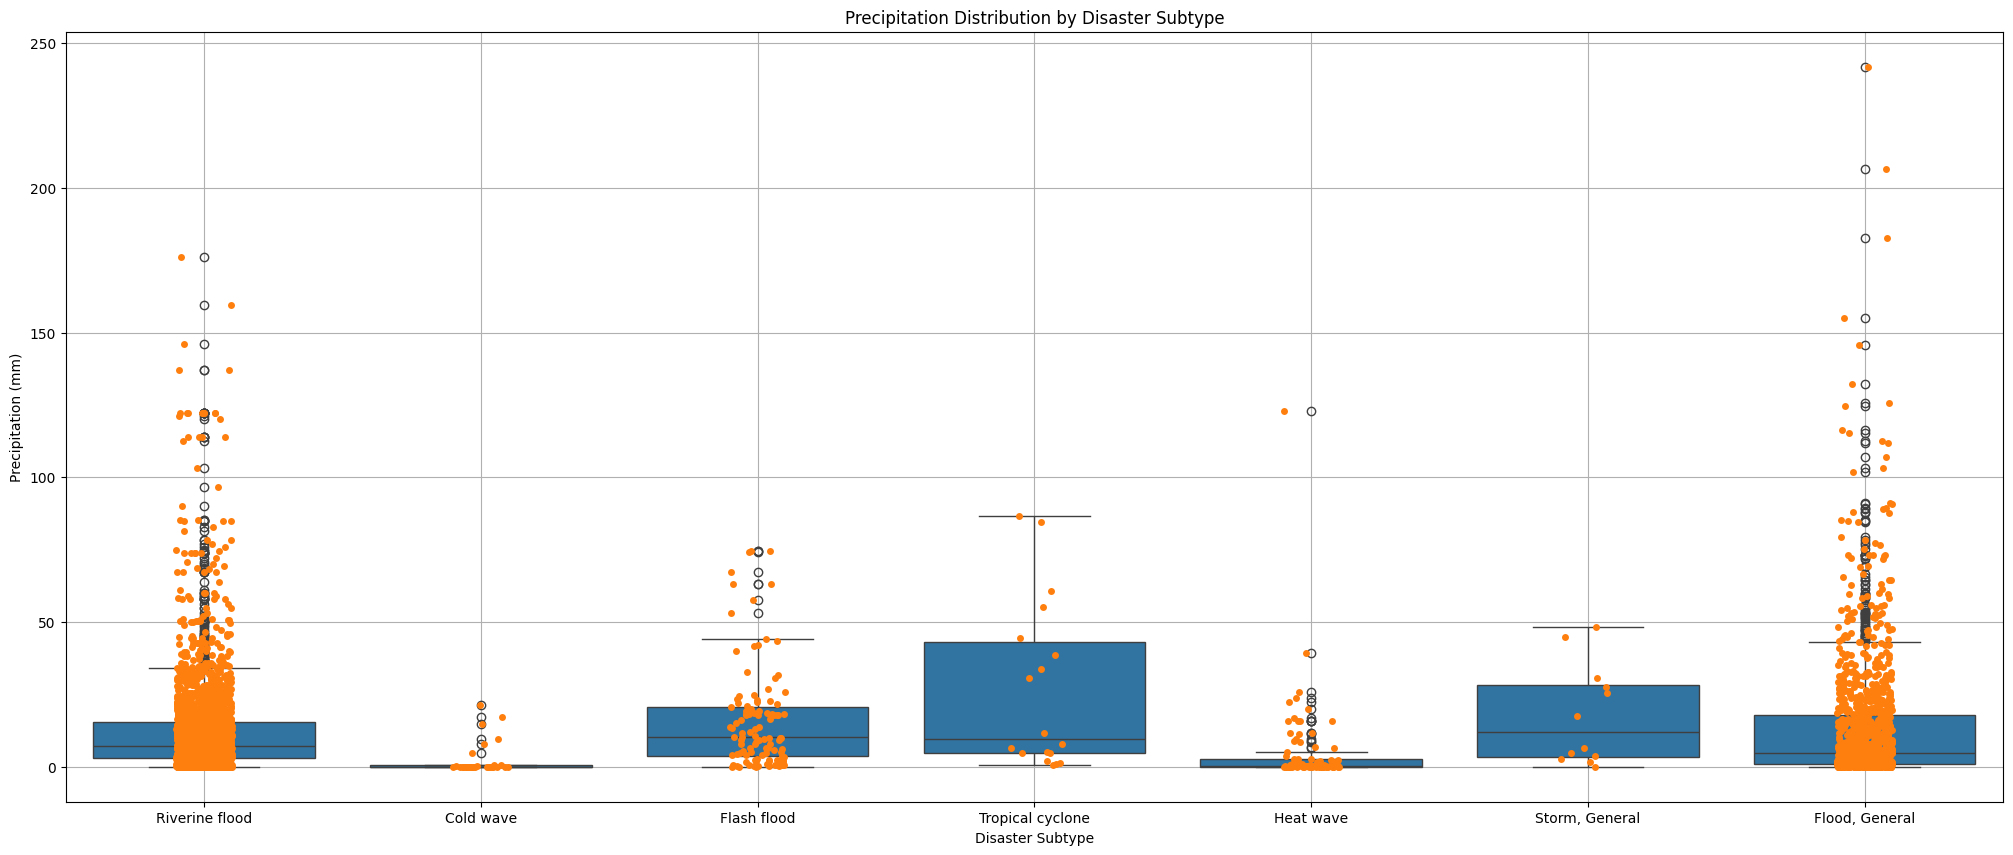

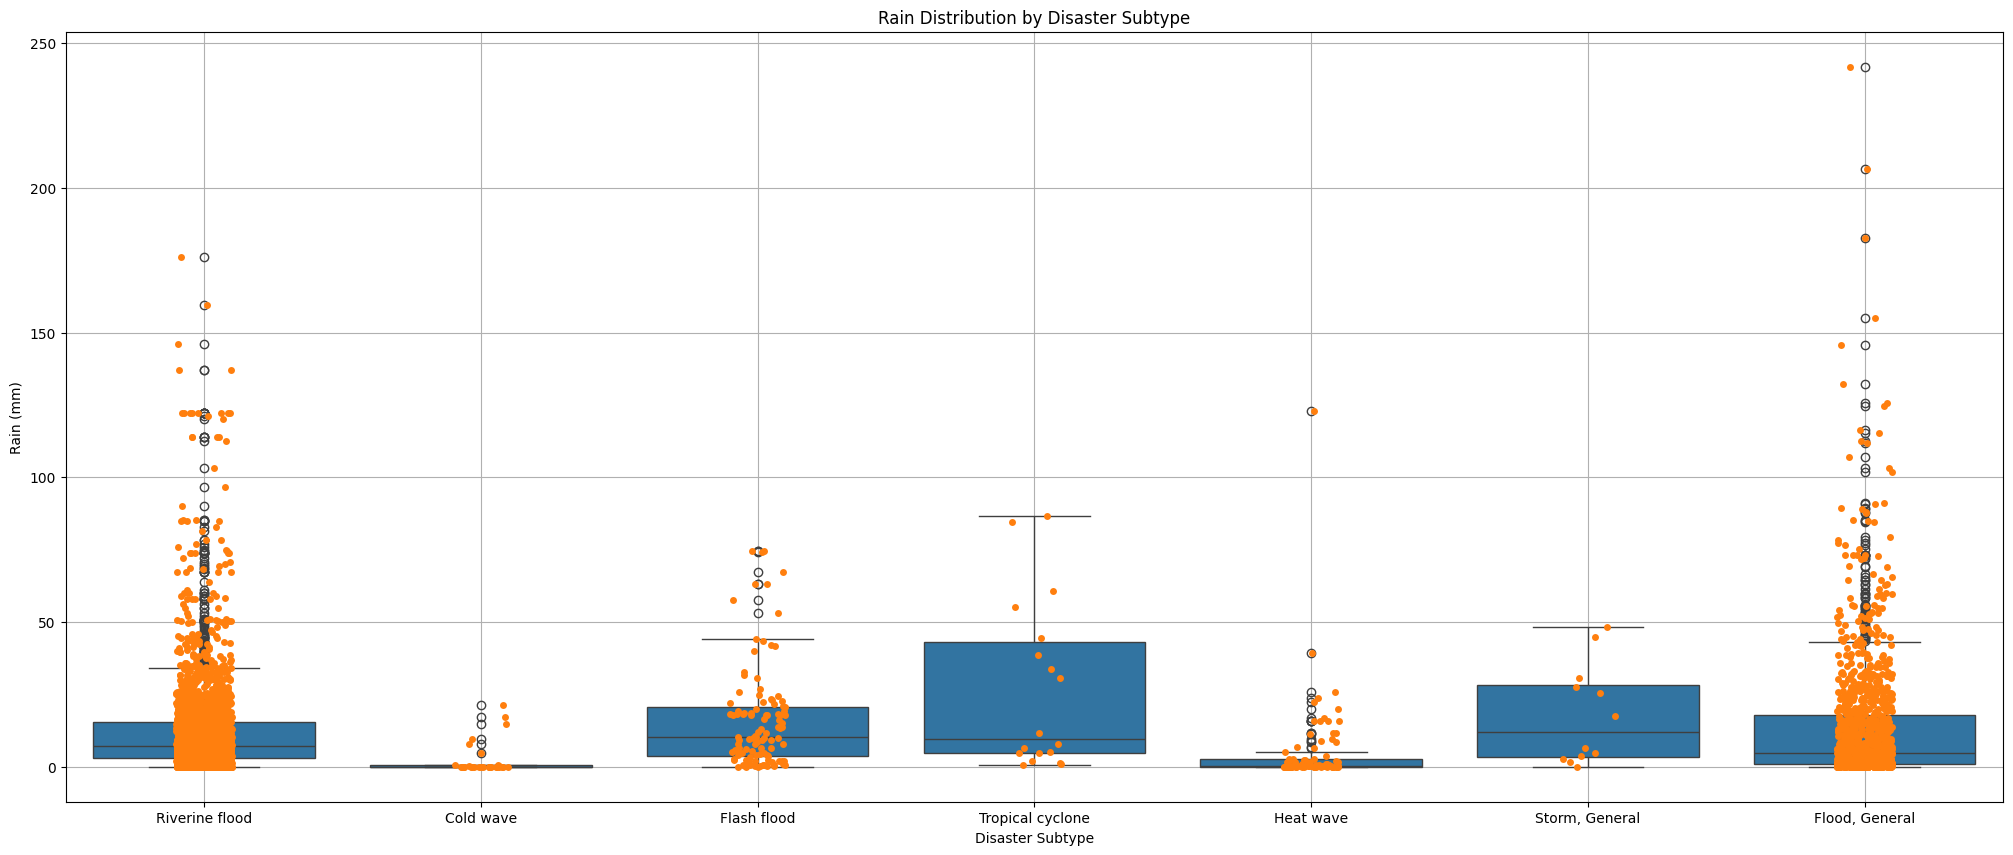

In [26]:
generate_bsplot(
    dataFrame=df,
    xv="disaster_subtype",
    yv="precipitation_sum",
    xlabel="Disaster Subtype",
    ylabel="Precipitation (mm)",
    title="Precipitation Distribution by Disaster Subtype"
    )

generate_bsplot(
    dataFrame=df,
    xv="disaster_subtype",
    yv="rain_sum",
    xlabel="Disaster Subtype",
    ylabel="Rain (mm)",
    title="Rain Distribution by Disaster Subtype"
    )

> Precipitation (h)

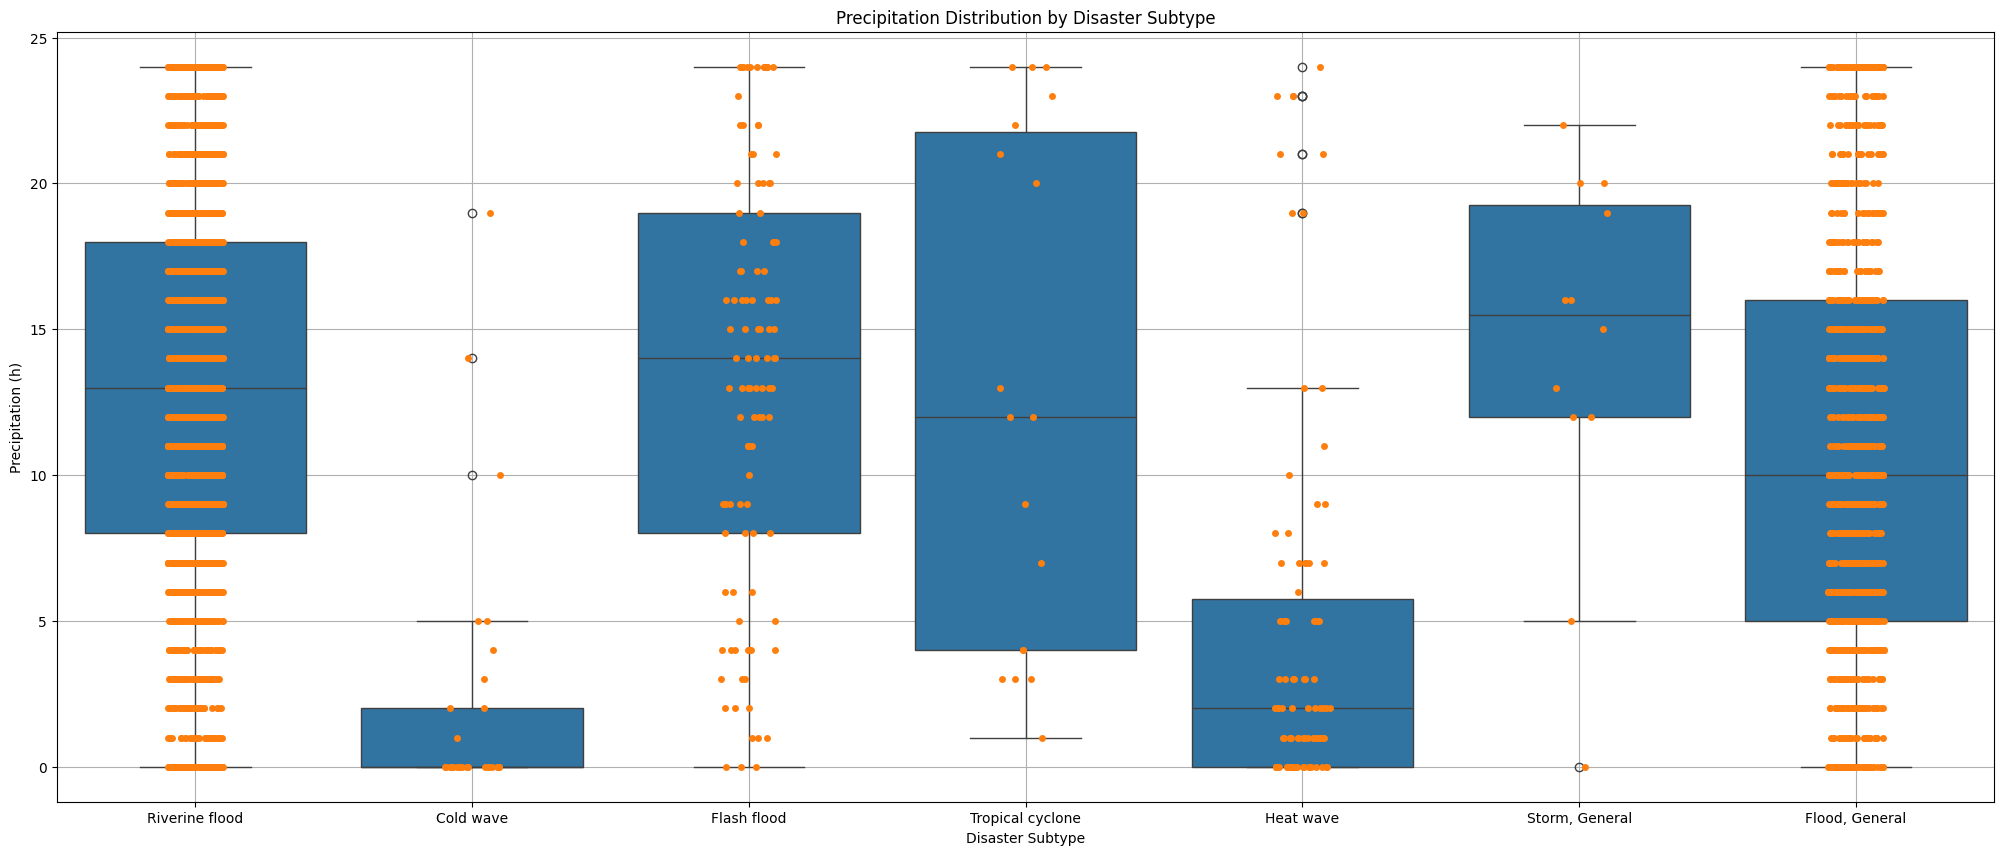

In [27]:
generate_bsplot(
    dataFrame=df,
    xv="disaster_subtype",
    yv="precipitation_hours",
    xlabel="Disaster Subtype",
    ylabel="Precipitation (h)",
    title="Precipitation Distribution by Disaster Subtype"
    )

> Wind speed 10m

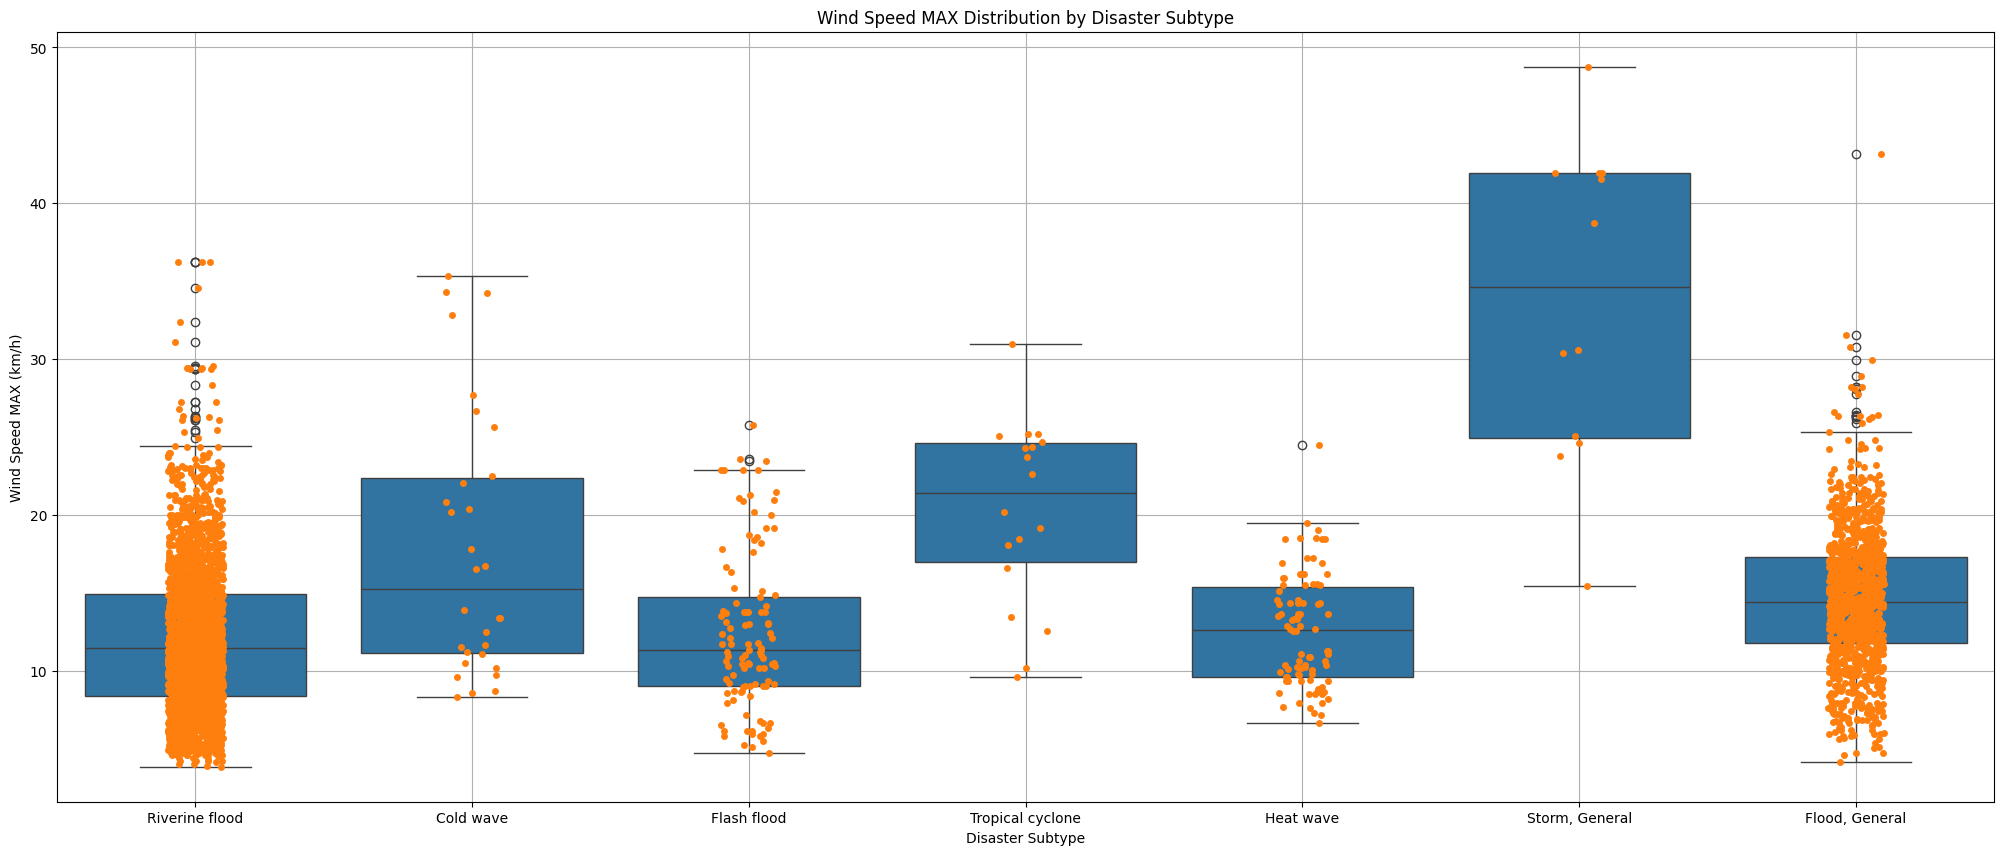

In [28]:
generate_bsplot(
    dataFrame=df,
    xv="disaster_subtype",
    yv="wind_speed_10m_max",
    xlabel="Disaster Subtype",
    ylabel="Wind Speed MAX (km/h)",
    title="Wind Speed MAX Distribution by Disaster Subtype"
    )

> Wind gusts 10m

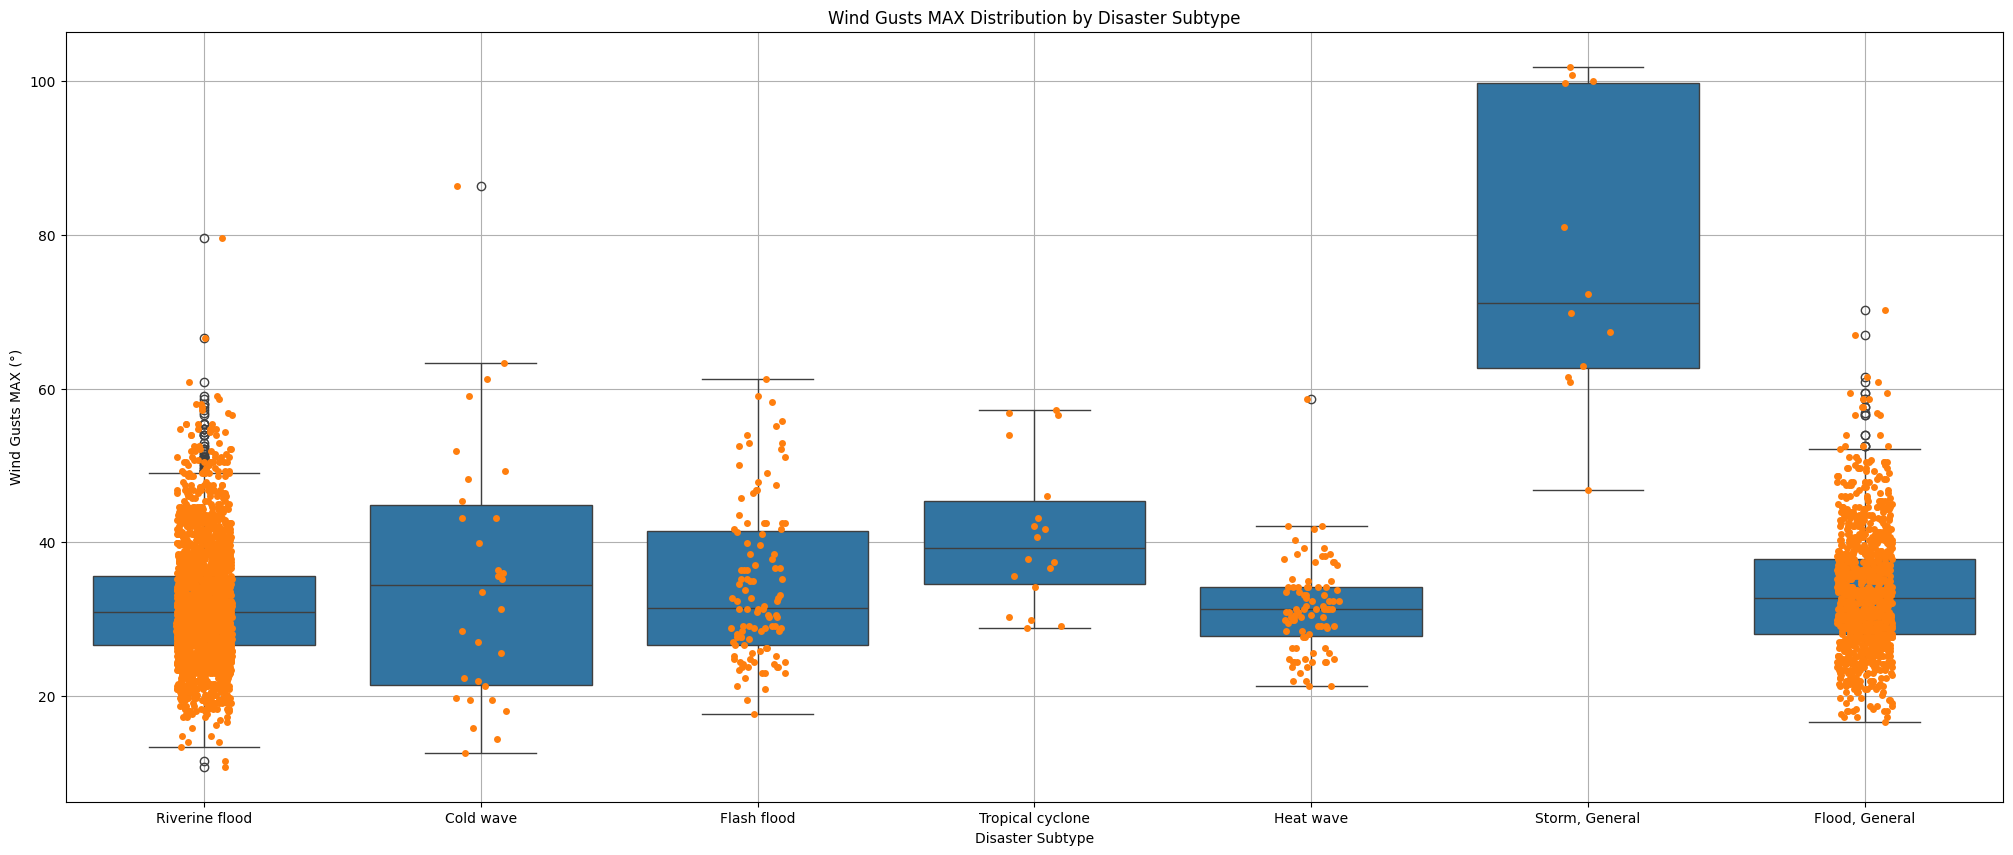

In [29]:
generate_bsplot(
    dataFrame=df,
    xv="disaster_subtype",
    yv="wind_gusts_10m_max",
    xlabel="Disaster Subtype",
    ylabel="Wind Gusts MAX (°)",
    title="Wind Gusts MAX Distribution by Disaster Subtype"
    )

> Wind direction 10m

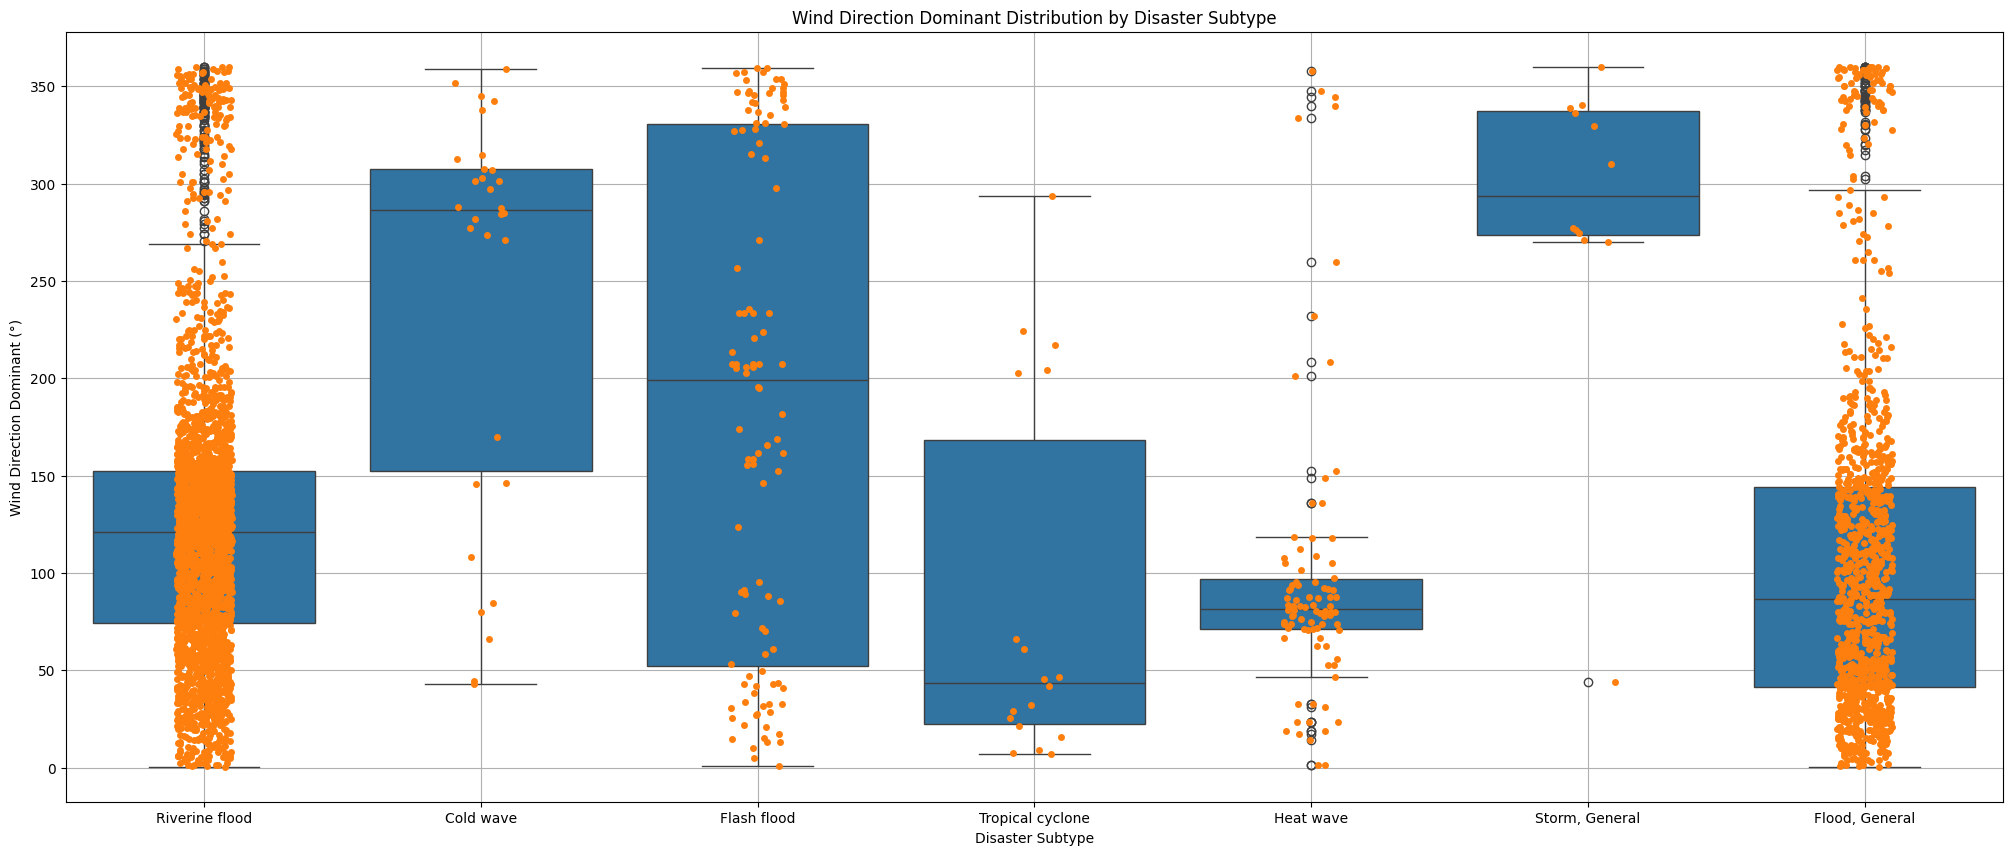

In [30]:
generate_bsplot(
    dataFrame=df,
    xv="disaster_subtype",
    yv="wind_direction_10m_dominant",
    xlabel="Disaster Subtype",
    ylabel="Wind Direction Dominant (°)",
    title="Wind Direction Dominant Distribution by Disaster Subtype"
    )

> Shortware radiation sum

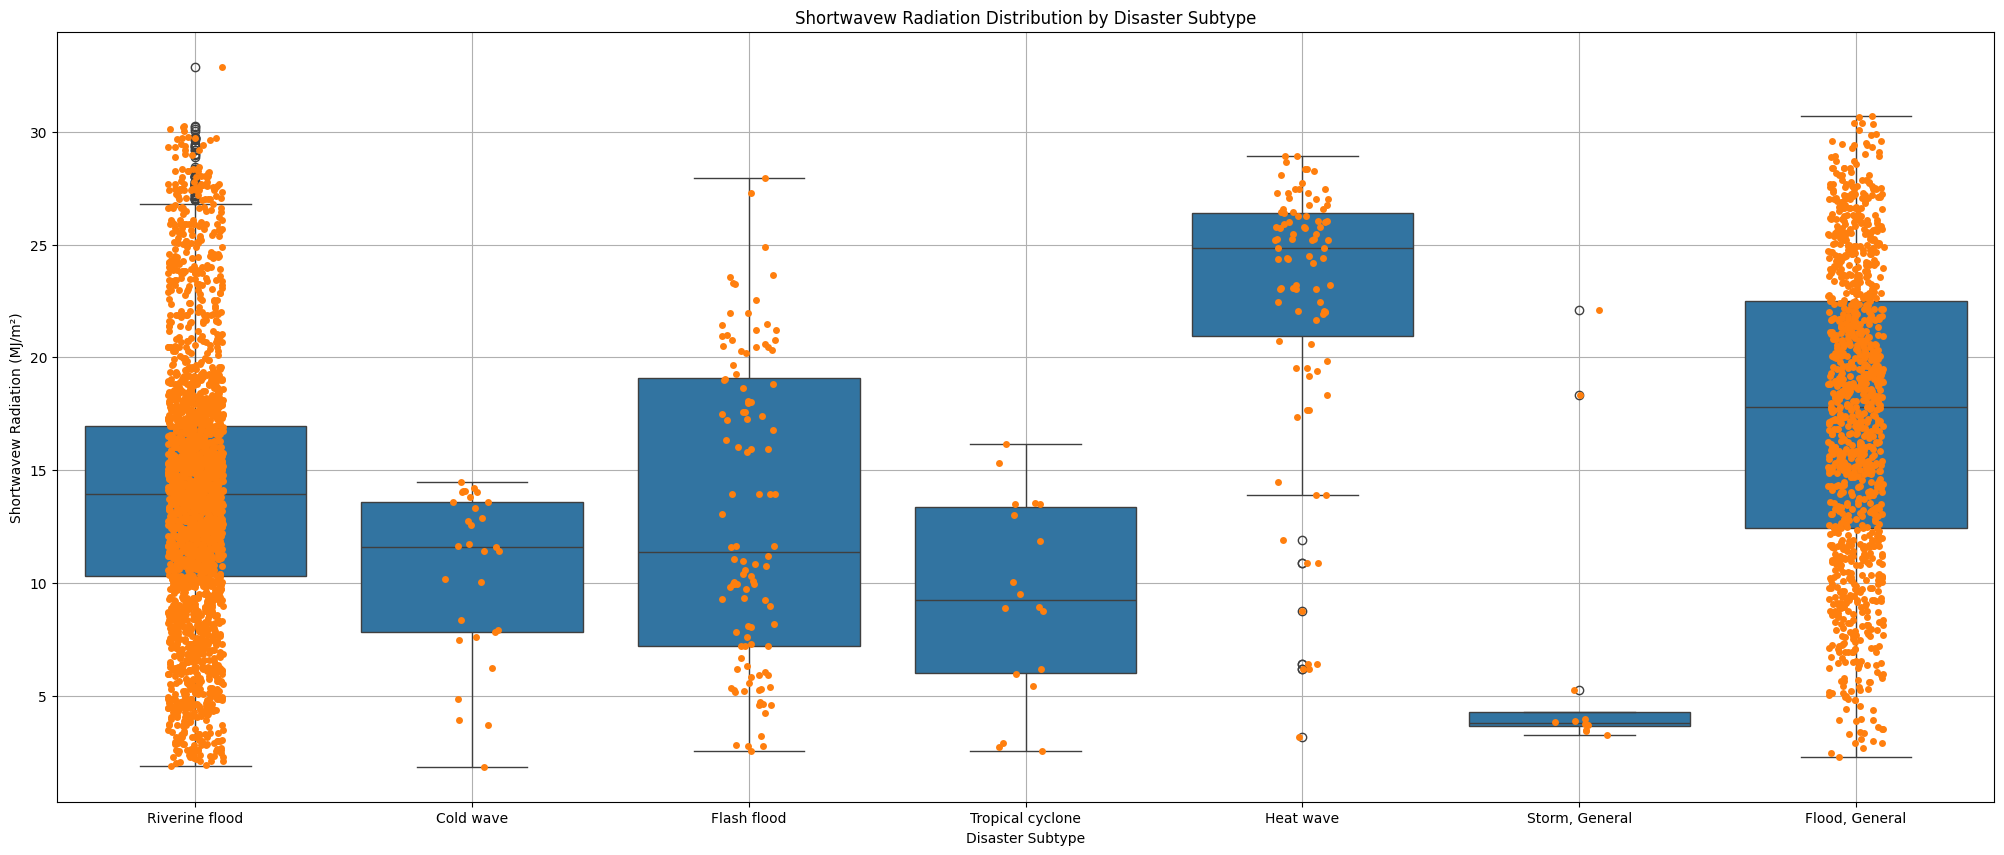

In [31]:
generate_bsplot(
    dataFrame=df,
    xv="disaster_subtype",
    yv="shortwave_radiation_sum",
    xlabel="Disaster Subtype",
    ylabel="Shortwavew Radiation (MJ/m²)",
    title="Shortwavew Radiation Distribution by Disaster Subtype"
    )

> Evapotranspiration

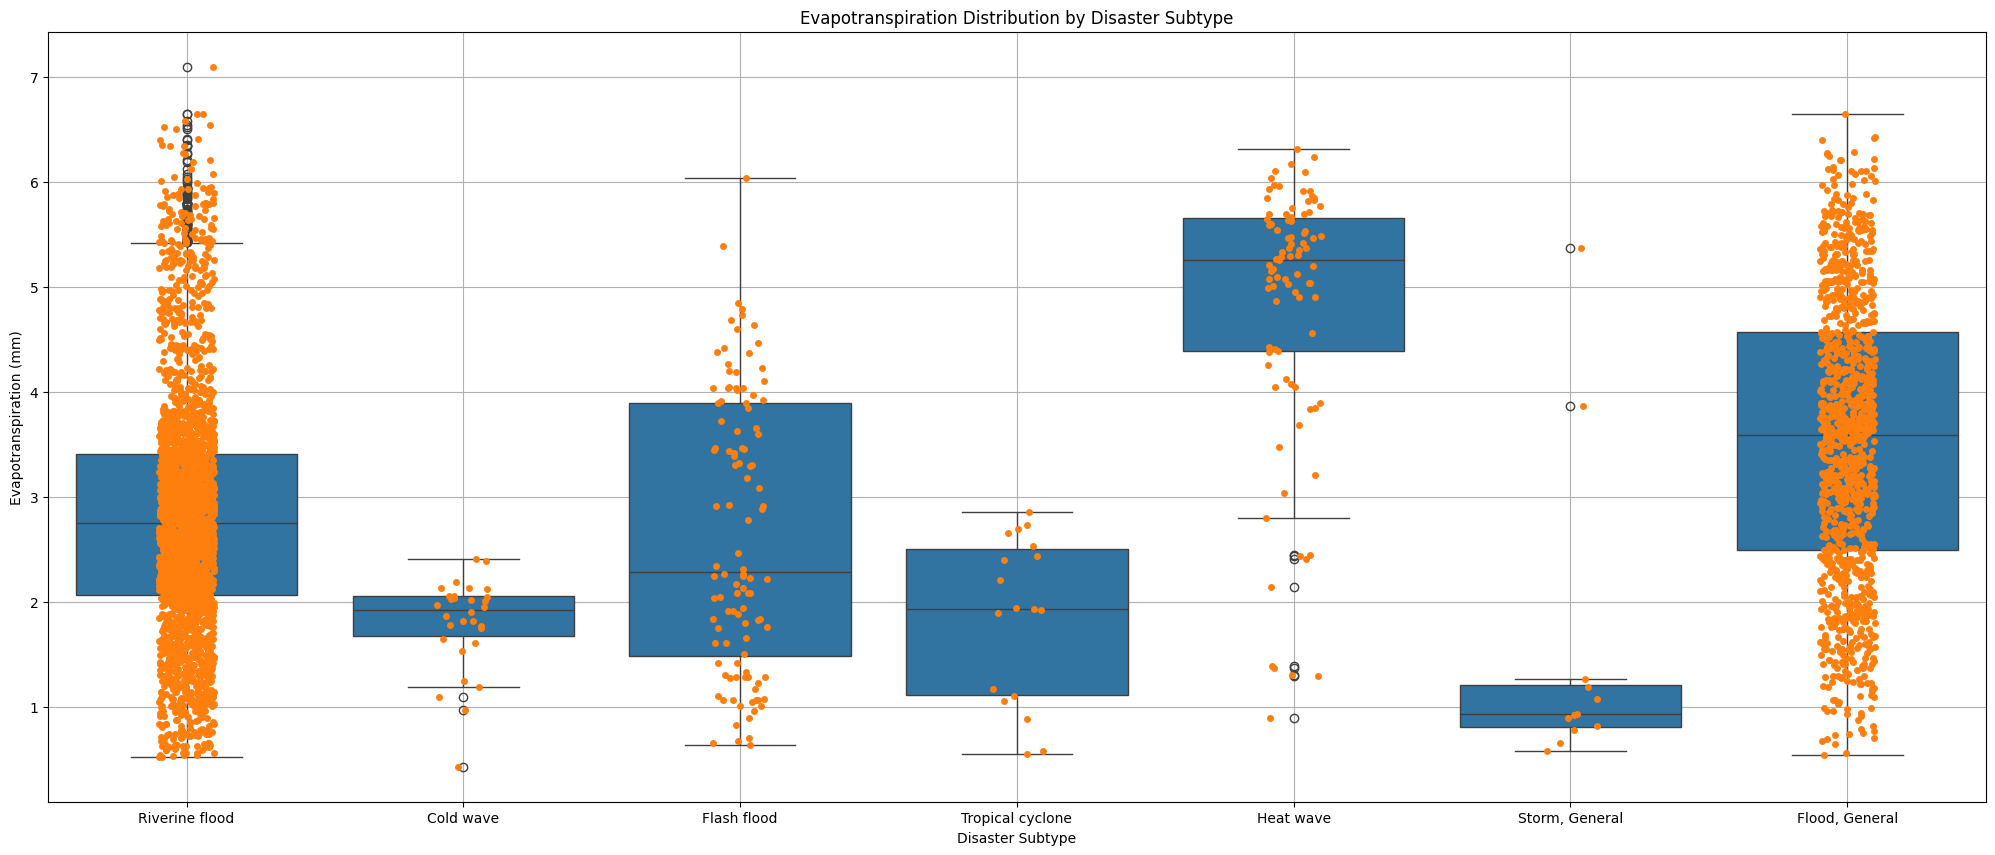

In [32]:
generate_bsplot(
    dataFrame=df,
    xv="disaster_subtype",
    yv="et0_fao_evapotranspiration",
    xlabel="Disaster Subtype",
    ylabel="Evapotranspiration (mm)",
    title="Evapotranspiration Distribution by Disaster Subtype"
    )

### Viewing correlated data categorized by disaster subtypes


In [33]:
df_ = df.drop(["disaster_subtype_code"], axis=1)

> Riverine flood

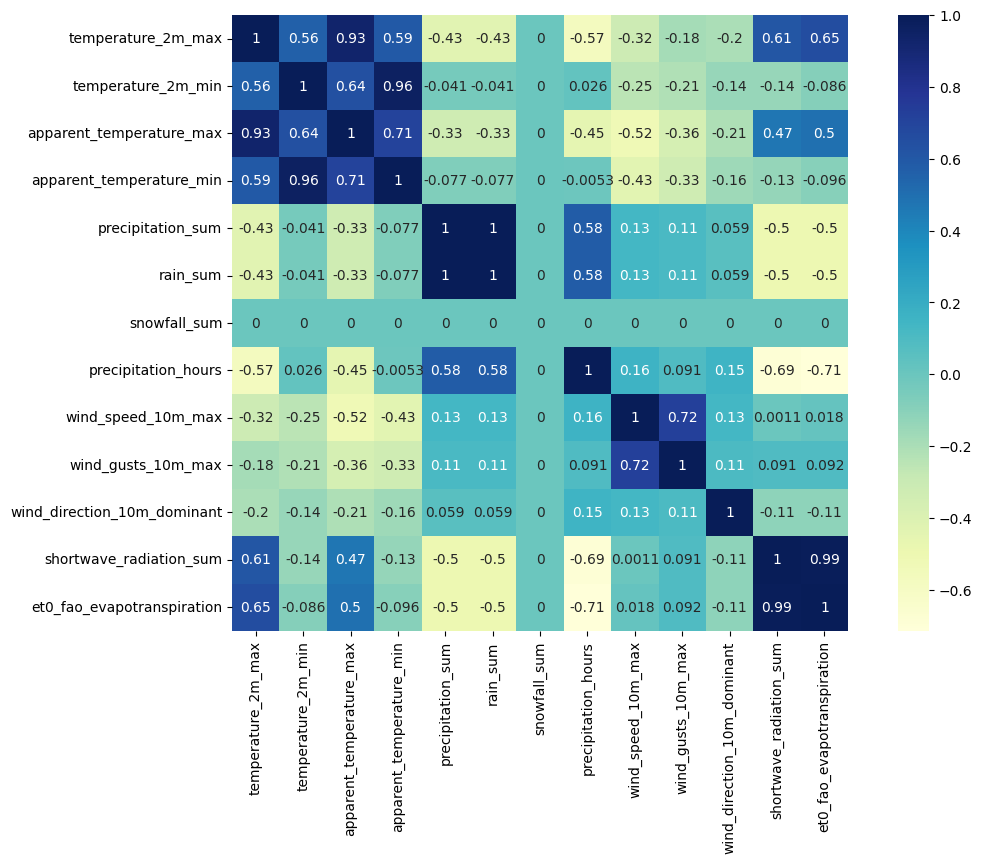

In [34]:
rf_corr = generate_heatmap(df_, "Riverine flood")

In [35]:
get_correlation_variables(dataFrame=df_, disaster_subtype="Riverine flood")

temperature_2m_max           temperature_2m_max             True
                             apparent_temperature_max       True
temperature_2m_min           temperature_2m_min             True
                             apparent_temperature_min       True
apparent_temperature_max     temperature_2m_max             True
                             apparent_temperature_max       True
apparent_temperature_min     temperature_2m_min             True
                             apparent_temperature_min       True
precipitation_sum            precipitation_sum              True
                             rain_sum                       True
rain_sum                     precipitation_sum              True
                             rain_sum                       True
precipitation_hours          precipitation_hours            True
wind_speed_10m_max           wind_speed_10m_max             True
wind_gusts_10m_max           wind_gusts_10m_max             True
wind_direction_10m_domina

> Cold wave

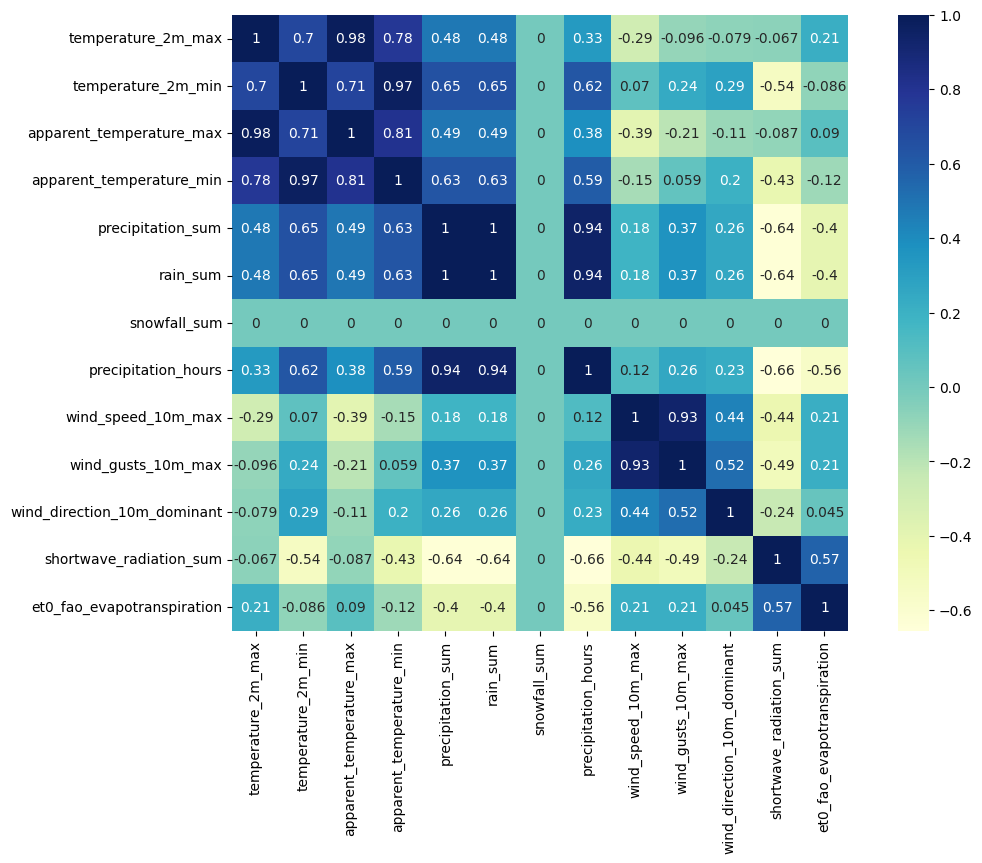

In [36]:
cw_corr = generate_heatmap(df_, "Cold wave")

In [37]:
get_correlation_variables(dataFrame=df_, disaster_subtype="Cold wave")

temperature_2m_max           temperature_2m_max             True
                             apparent_temperature_max       True
temperature_2m_min           temperature_2m_min             True
                             apparent_temperature_min       True
apparent_temperature_max     temperature_2m_max             True
                             apparent_temperature_max       True
apparent_temperature_min     temperature_2m_min             True
                             apparent_temperature_min       True
precipitation_sum            precipitation_sum              True
                             rain_sum                       True
                             precipitation_hours            True
rain_sum                     precipitation_sum              True
                             rain_sum                       True
                             precipitation_hours            True
precipitation_hours          precipitation_sum              True
                         

> Flash flood

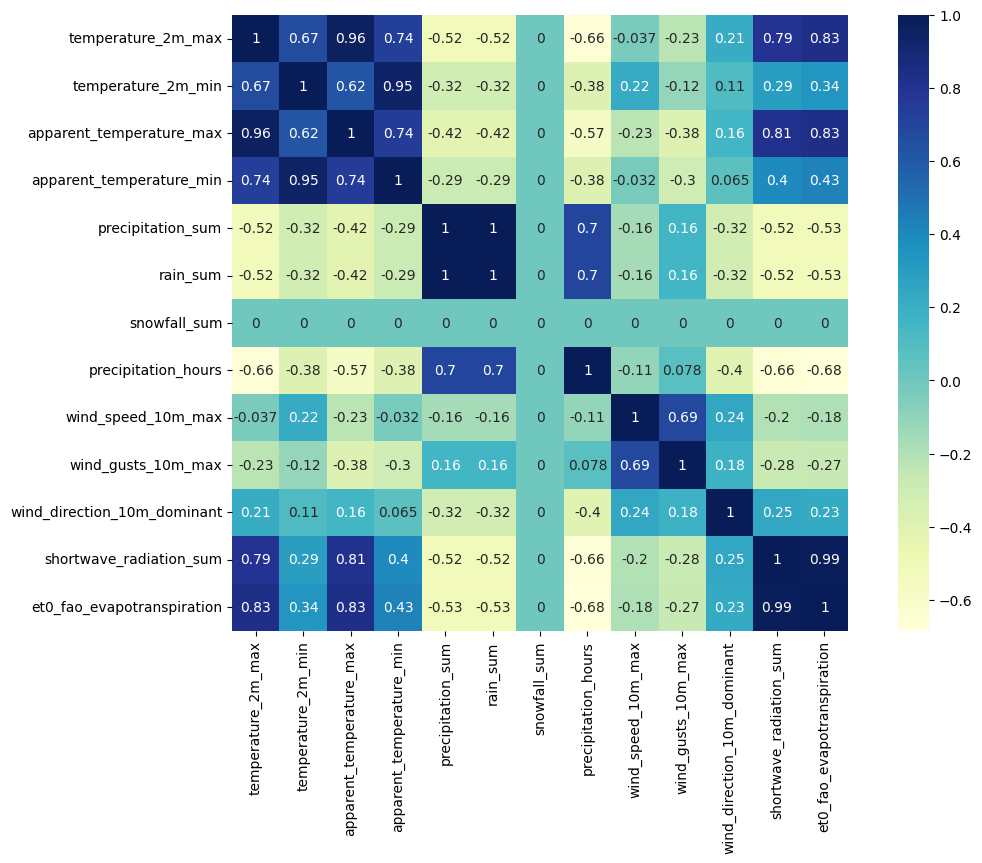

In [38]:
ff_corr = generate_heatmap(df_, "Flash flood")

In [39]:
get_correlation_variables(dataFrame=df_, disaster_subtype="Flash flood")

temperature_2m_max           temperature_2m_max             True
                             apparent_temperature_max       True
temperature_2m_min           temperature_2m_min             True
                             apparent_temperature_min       True
apparent_temperature_max     temperature_2m_max             True
                             apparent_temperature_max       True
apparent_temperature_min     temperature_2m_min             True
                             apparent_temperature_min       True
precipitation_sum            precipitation_sum              True
                             rain_sum                       True
rain_sum                     precipitation_sum              True
                             rain_sum                       True
precipitation_hours          precipitation_hours            True
wind_speed_10m_max           wind_speed_10m_max             True
wind_gusts_10m_max           wind_gusts_10m_max             True
wind_direction_10m_domina

> Tropical cyclone

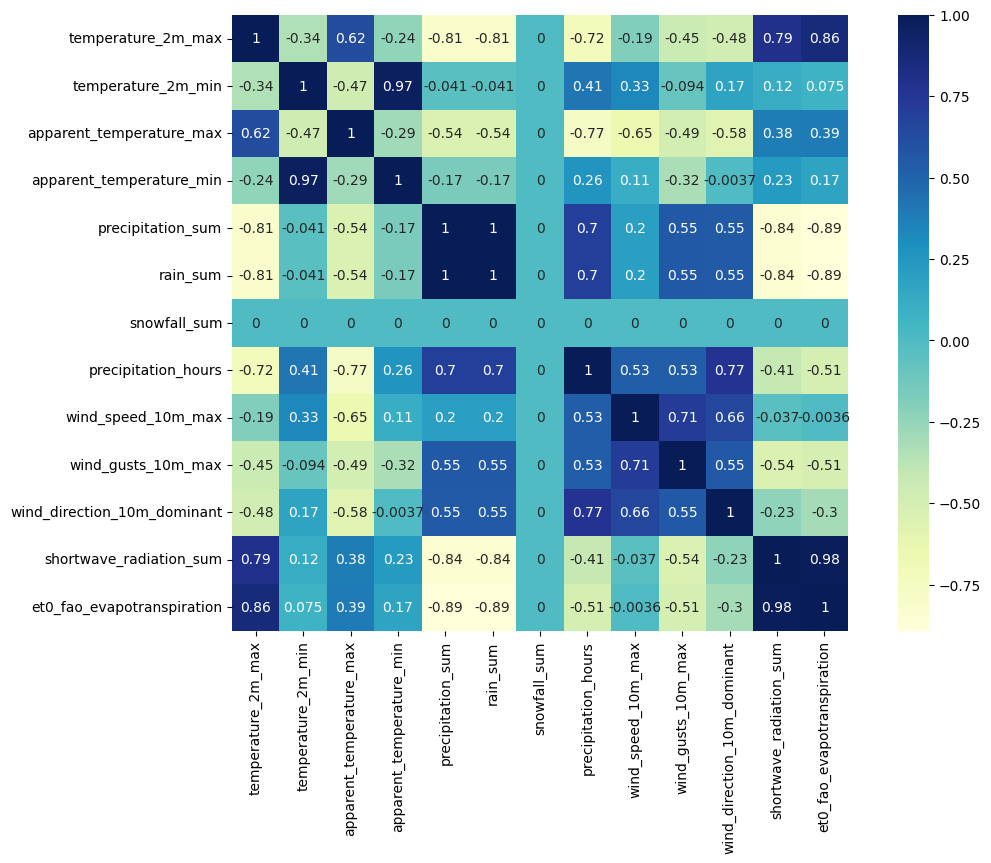

In [40]:
tc_corr = generate_heatmap(df_, "Tropical cyclone")

In [41]:
get_correlation_variables(dataFrame=df_, disaster_subtype="Tropical cyclone")

temperature_2m_max           temperature_2m_max             True
temperature_2m_min           temperature_2m_min             True
                             apparent_temperature_min       True
apparent_temperature_max     apparent_temperature_max       True
apparent_temperature_min     temperature_2m_min             True
                             apparent_temperature_min       True
precipitation_sum            precipitation_sum              True
                             rain_sum                       True
rain_sum                     precipitation_sum              True
                             rain_sum                       True
precipitation_hours          precipitation_hours            True
wind_speed_10m_max           wind_speed_10m_max             True
wind_gusts_10m_max           wind_gusts_10m_max             True
wind_direction_10m_dominant  wind_direction_10m_dominant    True
shortwave_radiation_sum      shortwave_radiation_sum        True
                         

> Heat wave

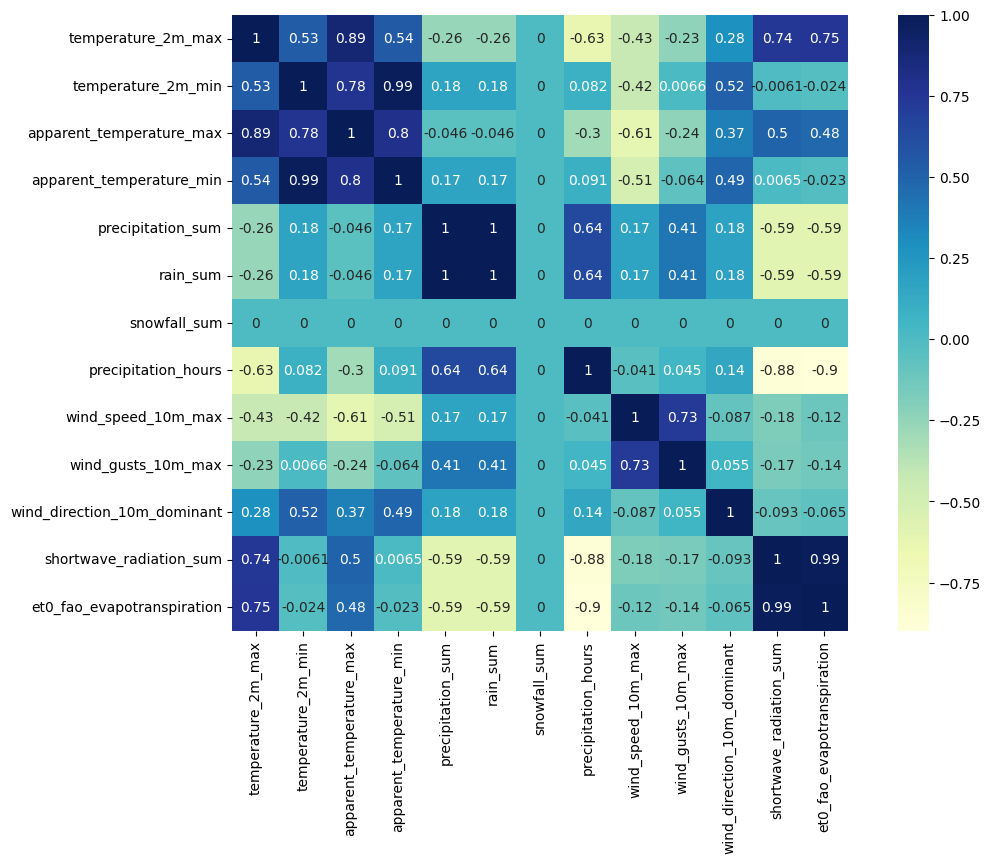

In [42]:
hw_corr = generate_heatmap(df_, "Heat wave")

In [43]:
get_correlation_variables(dataFrame=df_, disaster_subtype="Heat wave")

temperature_2m_max           temperature_2m_max             True
temperature_2m_min           temperature_2m_min             True
                             apparent_temperature_min       True
apparent_temperature_max     apparent_temperature_max       True
apparent_temperature_min     temperature_2m_min             True
                             apparent_temperature_min       True
precipitation_sum            precipitation_sum              True
                             rain_sum                       True
rain_sum                     precipitation_sum              True
                             rain_sum                       True
precipitation_hours          precipitation_hours            True
wind_speed_10m_max           wind_speed_10m_max             True
wind_gusts_10m_max           wind_gusts_10m_max             True
wind_direction_10m_dominant  wind_direction_10m_dominant    True
shortwave_radiation_sum      shortwave_radiation_sum        True
                         

Storm, General

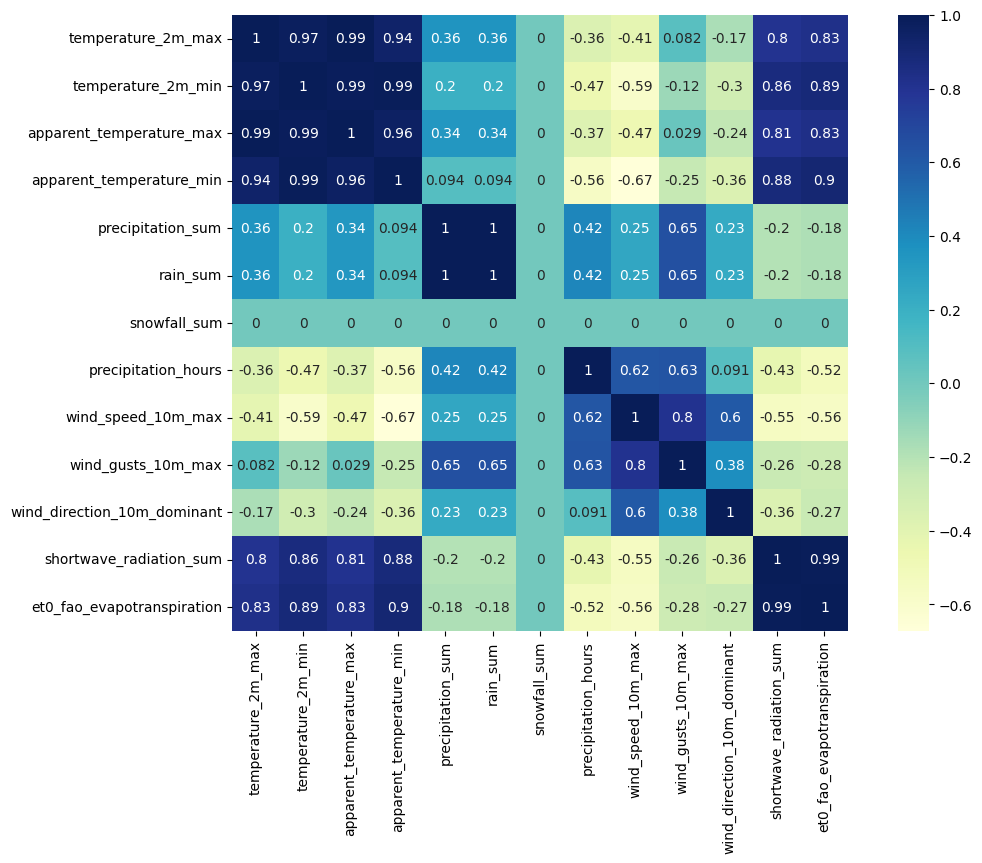

In [44]:
sg_corr = generate_heatmap(df_, "Storm, General")

In [45]:
get_correlation_variables(dataFrame=df_, disaster_subtype="Storm, General")

temperature_2m_max           temperature_2m_max             True
                             temperature_2m_min             True
                             apparent_temperature_max       True
                             apparent_temperature_min       True
temperature_2m_min           temperature_2m_max             True
                             temperature_2m_min             True
                             apparent_temperature_max       True
                             apparent_temperature_min       True
apparent_temperature_max     temperature_2m_max             True
                             temperature_2m_min             True
                             apparent_temperature_max       True
                             apparent_temperature_min       True
apparent_temperature_min     temperature_2m_max             True
                             temperature_2m_min             True
                             apparent_temperature_max       True
                         

> Flood, General

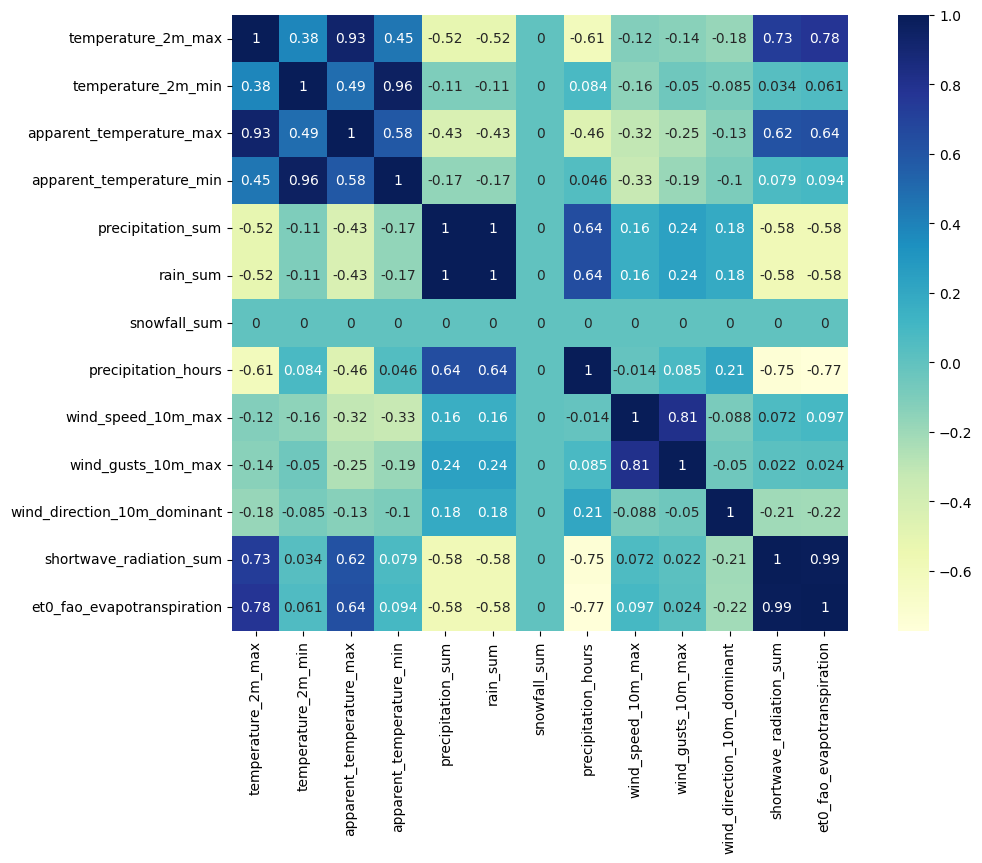

In [46]:
fg_corr = generate_heatmap(df_, "Flood, General")

In [47]:
get_correlation_variables(dataFrame=df_, disaster_subtype="Flood, General")

temperature_2m_max           temperature_2m_max             True
                             apparent_temperature_max       True
temperature_2m_min           temperature_2m_min             True
                             apparent_temperature_min       True
apparent_temperature_max     temperature_2m_max             True
                             apparent_temperature_max       True
apparent_temperature_min     temperature_2m_min             True
                             apparent_temperature_min       True
precipitation_sum            precipitation_sum              True
                             rain_sum                       True
rain_sum                     precipitation_sum              True
                             rain_sum                       True
precipitation_hours          precipitation_hours            True
wind_speed_10m_max           wind_speed_10m_max             True
wind_gusts_10m_max           wind_gusts_10m_max             True
wind_direction_10m_domina

#OPEN-METEO - Weather Forecast API



> Load weather information from API

## API call

> Algorithm for processing data (Search weather from latitude and longitude)


In [81]:
# Setup the Open-Meteo API client with cache and retry on error
# Cache session to store API responses locally with expiration time of 1 hour (3600 seconds)
cache_session = requests_cache.CachedSession('.cache', expire_after=3600)
# Retry session to automatically retry requests in case of errors with maximum of 5 retries and backoff factor of 0.2
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
# Create Open-Meteo API client with the retry session
openmeteo = openmeteo_requests.Client(session=retry_session)

# Function to search for weather information using Open-Meteo API
def search_info_weather_(latitude, longitude):
    # Define parameters for weather API request
    params = {
        "latitude": latitude,   # Latitude of the location
        "longitude": longitude, # Longitude of the location
        "daily": [
            "temperature_2m_max",
            "temperature_2m_min",
            "apparent_temperature_max",
            "apparent_temperature_min",
            "precipitation_sum",
            "rain_sum",
            "snowfall_sum",
            "precipitation_hours",
            "wind_speed_10m_max",
            "wind_gusts_10m_max",
            "wind_direction_10m_dominant",
            "shortwave_radiation_sum",
            "et0_fao_evapotranspiration"
        ],
        "timezone": "America/Sao_Paulo", # Timezone for the location
	    "past_days": 0,                 # Retrieve weather data for the past 0 days
        "forecast_days": 14,              # Retrieve weather forecast for 14 day
        "models": [
            "best_match"
        ]
    }

    # Call Open-Meteo API to retrieve weather data
    responses = openmeteo.weather_api(userdata.get('api_url_openmeteo_forecast'), params=params)

    # Process first location. Add a for-loop for multiple locations or weather models
    response = responses[0]

    # Process daily weather data
    daily = response.Daily()
    variables = [daily.Variables(i).ValuesAsNumpy() for i in range(13)]
    variable_names = [
        "temperature_2m_max",
        "temperature_2m_min",
        "apparent_temperature_max",
        "apparent_temperature_min",
        "precipitation_sum",
        "rain_sum",
        "snowfall_sum",
        "precipitation_hours",
        "wind_speed_10m_max",
        "wind_gusts_10m_max",
        "wind_direction_10m_dominant",
        "shortwave_radiation_sum",
        "et0_fao_evapotranspiration"
    ]

    # Create dictionary to store daily weather data
    daily_data = {"date": pd.date_range(
        start=pd.to_datetime(daily.Time(), unit="s"),
        end=pd.to_datetime(daily.TimeEnd(), unit="s"),
        freq=pd.Timedelta(seconds=daily.Interval()),
        inclusive="left"
    )}
    # Add latitude and longitude information to daily data dictionary
    daily_data["latitude"] = response.Latitude()
    daily_data["longitude"] = response.Longitude()

    # Add weather variables to daily data dictionary
    for name, values in zip(variable_names, variables):
        daily_data[name] = values

    return daily_data

> Getting information and formatting dataframe

In [82]:
from datetime import date

# Initialize an empty list to store weather information
_weather_structure = []

# Call the search_info_weather_ function to retrieve weather information for a specific location
# Latitude and longitude coordinates are provided as arguments
_info = search_info_weather_(
    latitude=-12.8839628,     # Latitude of the location
    longitude=-38.4376571  # Longitude of the location
)

#-22.913158,-43.7756525 - RIO DE JANEIRO
# Append the retrieved weather information to the _weather_structure list
_weather_structure.append(_info)

##Data visualization without processing

In [83]:
df__ = pd.DataFrame(data = _weather_structure)
display(df__)

date  latitude  longitude  \
0  DatetimeIndex(['2024-03-30 03:00:00', '2024-03...   -12.875      -38.5   

                                  temperature_2m_max  \
0  [29.969, 30.619, 30.769, 28.818998, 29.869, 27...   

                                  temperature_2m_min  \
0  [25.668999, 25.668999, 26.719, 25.869, 25.5689...   

                            apparent_temperature_max  \
0  [35.78838, 36.516907, 36.634624, 33.910343, 36...   

                            apparent_temperature_min  \
0  [30.64851, 31.176964, 32.096436, 31.699776, 31...   

                                   precipitation_sum  \
0  [0.6, 0.0, 0.0, 10.200002, 5.899999, 20.2, 17....   

                                            rain_sum  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                        snowfall_sum  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                 precipitation_hours  \
0  [6.0, 0.0, 0.0, 18.0, 12.0, 24.0, 13.0, 9.0, 6...   

                                  wind_speed_10m_max  \
0  [12.522619, 11.91812, 14.81259, 10.315115, 12....   

                                  wind_gusts_10m_max  \
0  [25.199999, 24.119999, 29.16, 20.880001, 24.48...   

                         wind_direction_10m_dominant  \
0  [146.54666, 134.34795, 144.70032, 127.66146, 1...   

                             shortwave_radiation_sum  \
0  [21.58, 21.45, 21.08, 15.22, 20.04, 8.94, 14.9...   

                          et0_fao_evapotranspiration  
0  [4.4743023, 4.513928, 4.548783, 3.1136475, 4.0...

## Reorganization of daily information structure

In [84]:
# List of columns to explode (convert list-like elements into separate rows)
columns_to_explode = [
    'date',
    'temperature_2m_max',
    'temperature_2m_min',
    'apparent_temperature_max',
    'apparent_temperature_min',
    'precipitation_sum',
    'rain_sum',
    'snowfall_sum',
    'precipitation_hours',
    'wind_speed_10m_max',
    'wind_gusts_10m_max',
    'wind_direction_10m_dominant',
    'shortwave_radiation_sum',
    'et0_fao_evapotranspiration'
]

# Explode specified columns in the DataFrame df__ (convert list-like elements into separate rows)
df__ = df__.explode(columns_to_explode)


##Data visualization daily information

In [85]:
# Dictionary specifying the data type for each column in the DataFrame
_data_type = {
    'date': object,                             # Date as object
    'temperature_2m_max': float,               # Maximum temperature at 2m as float
    'temperature_2m_min': float,               # Minimum temperature at 2m as float
    'apparent_temperature_max': float,         # Maximum apparent temperature as float
    'apparent_temperature_min': float,         # Minimum apparent temperature as float
    'precipitation_sum': float,                # Precipitation sum as float
    'rain_sum': float,                         # Rain sum as float
    'snowfall_sum': float,                     # Snowfall sum as float
    'precipitation_hours': float,              # Precipitation hours as float
    'wind_speed_10m_max': float,               # Maximum wind speed at 10m as float
    'wind_gusts_10m_max': float,               # Maximum wind gusts at 10m as float
    'wind_direction_10m_dominant': float,      # Dominant wind direction at 10m as float
    'shortwave_radiation_sum': float,          # Shortwave radiation sum as float
    'et0_fao_evapotranspiration': float        # FAO evapotranspiration as float
}

# Convert DataFrame columns to specified data types using the _data_type dictionary
df__ = df__.astype(_data_type)

# Display the DataFrame
display(df__)

date  latitude  longitude  temperature_2m_max  \
0  2024-03-30 03:00:00   -12.875      -38.5           29.969000   
0  2024-03-31 03:00:00   -12.875      -38.5           30.618999   
0  2024-04-01 03:00:00   -12.875      -38.5           30.768999   
0  2024-04-02 03:00:00   -12.875      -38.5           28.818998   
0  2024-04-03 03:00:00   -12.875      -38.5           29.868999   
0  2024-04-04 03:00:00   -12.875      -38.5           27.318998   
0  2024-04-05 03:00:00   -12.875      -38.5           28.868999   
0  2024-04-06 03:00:00   -12.875      -38.5           29.181499   
0  2024-04-07 03:00:00   -12.875      -38.5           30.731499   
0  2024-04-08 03:00:00   -12.875      -38.5           30.981499   
0  2024-04-09 03:00:00   -12.875      -38.5           29.481499   
0  2024-04-10 03:00:00   -12.875      -38.5           34.731499   
0  2024-04-11 03:00:00   -12.875      -38.5           33.331501   
0  2024-04-12 03:00:00   -12.875      -38.5           31.131500   

   temperature_2m_min  apparent_temperature_max  apparent_temperature_min  \
0           25.668999                 35.788380                 30.648510   
0           25.668999                 36.516907                 31.176964   
0           26.719000                 36.634624                 32.096436   
0           25.868999                 33.910343                 31.699776   
0           25.568998                 36.591602                 31.782562   
0           24.969000                 32.362026                 30.459789   
0           25.818998                 32.382713                 29.659554   
0           23.731499                 34.901184                 28.073708   
0           22.681499                 35.045784                 27.463682   
0           22.531500                 36.188824                 27.285940   
0           22.131500                 35.841274                 25.047422   
0           21.731499                 40.610756                 24.997158   
0           22.831499                 39.101452                 27.644936   
0           23.181499                 36.350746                 27.400957   

   precipitation_sum  rain_sum  snowfall_sum  precipitation_hours  \
0           0.600000       0.0           0.0                  6.0   
0           0.000000       0.0           0.0                  0.0   
0           0.000000       0.0           0.0                  0.0   
0          10.200002       0.0           0.0                 18.0   
0           5.899999       0.0           0.0                 12.0   
0          20.200001       0.0           0.0                 24.0   
0          17.000000       0.0           0.0                 13.0   
0           2.100000       0.0           0.0                  9.0   
0           1.200000       0.0           0.0                  6.0   
0           1.100000       0.1           0.0                  8.0   
0           0.400000       0.2           0.0                  4.0   
0           0.000000       0.0           0.0                  0.0   
0           0.000000       0.0           0.0                  0.0   
0           1.500000       0.3           0.0                  6.0   

   wind_speed_10m_max  wind_gusts_10m_max  wind_direction_10m_dominant  \
0           12.522619           25.199999                   146.546661   
0           11.918120           24.119999                   134.347946   
0           14.812590           29.160000                   144.700317   
0           10.315115           20.880001                   127.661461   
0           12.229406           24.480000                   127.234924   
0           11.879999           25.199999                   189.578369   
0           20.883104           40.680000                   176.143265   
0           16.171976           31.680000                   149.448227   
0            9.673221           22.319998                   128.467911   
0           11.609651           22.319998                   141.888214   
0     

<Axes: >

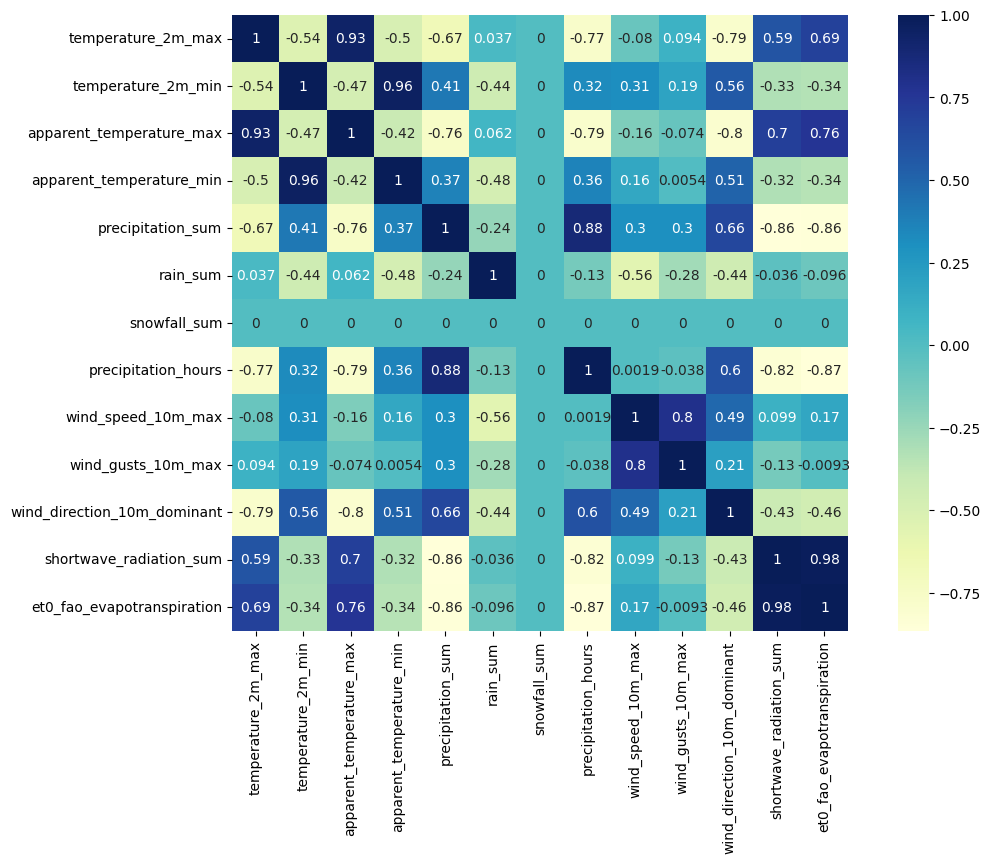

In [86]:
# Calculate correlation matrix for forecast data, dropping latitude, longitude, and snowfall_sum columns
forecast_corr = df__.drop(["latitude", "longitude"], axis=1).corr().fillna(0)

# Create a new figure and axis for the heatmap
f, ax = plt.subplots(figsize=(13, 8))

# Generate heatmap to visualize correlation matrix
sns.heatmap(
    forecast_corr,                # Correlation matrix to be visualized
    cmap="YlGnBu",                # Color map for heatmap
    square=True,                  # Make cells square-shaped
    annot=True                    # Annotate cells with correlation values
)

# Statistical Calculation

In [87]:
# Calculate the percentage of similarity between the forecast correlation matrix and each disaster subtype correlation matrix
disaster_subtypes = ['Riverine flood', 'Cold wave', 'Flash flood', 'Tropical cyclone', 'Heat wave', 'Storm, General', 'Flood, General']

### Statistical Correlation Coefficient


Coeficiente de Correlação Estatistica: 1.3299932752581545 : 0.18532329139739673
Não há diferença estatisticamente significativa entre as correlações.
Coeficiente de Correlação Estatistica: 4.621333835620753 : 7.5633416937527866e-06
As correlações são estatisticamente diferentes.
Coeficiente de Correlação Estatistica: 1.6295175579923844 : 0.10507708981331312
Não há diferença estatisticamente significativa entre as correlações.
Coeficiente de Correlação Estatistica: 0.8875688792244616 : 0.3760416071841993
Não há diferença estatisticamente significativa entre as correlações.
Coeficiente de Correlação Estatistica: 2.744339994004559 : 0.0067225075998185975
As correlações são estatisticamente diferentes.
Coeficiente de Correlação Estatistica: 4.071488710573446 : 7.180554260414263e-05
As correlações são estatisticamente diferentes.
Coeficiente de Correlação Estatistica: 1.7675348863050622 : 0.07895411018544536
Não há diferença estatisticamente significativa entre as correlações.


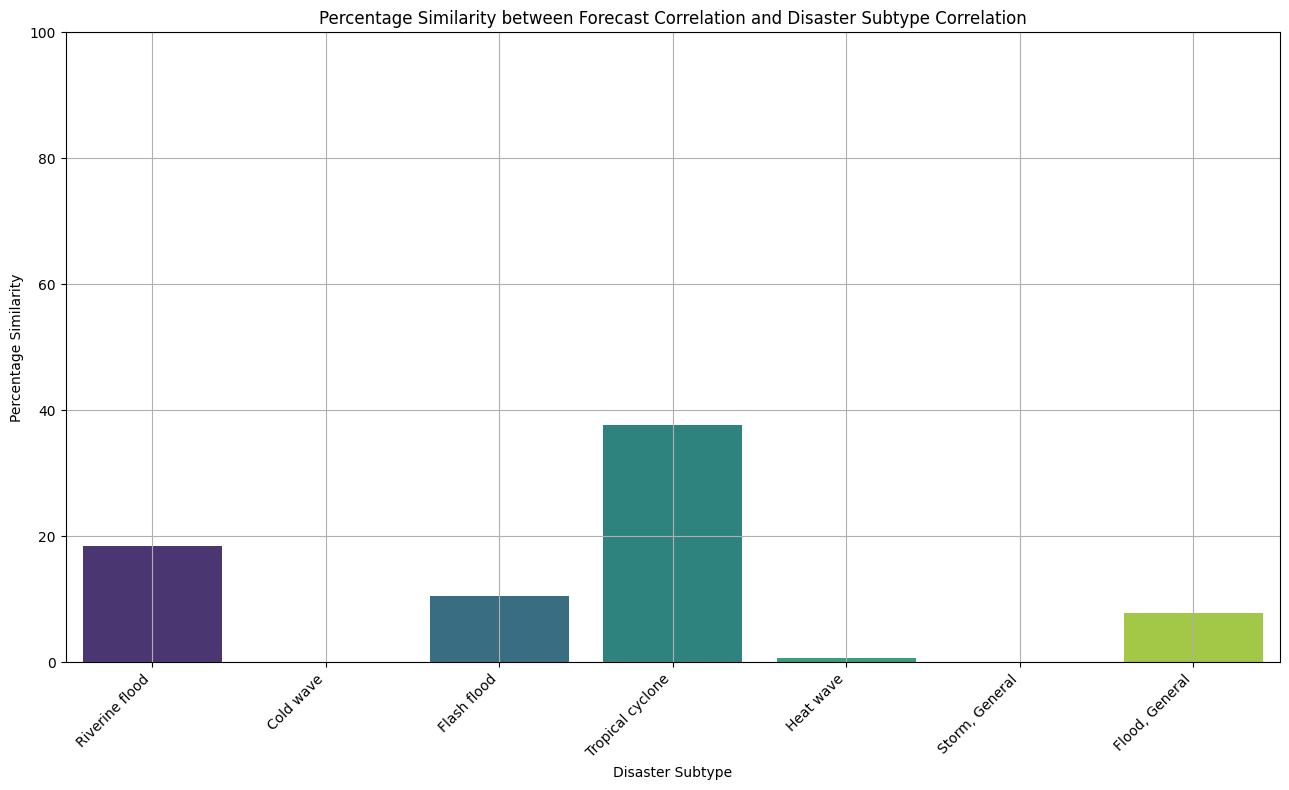

In [88]:
# Function to calculate the percentage similarity between correlation matrices
def calculate_percentage_similarity(correlation_1, correlation_2):

    statistic, p_value = ttest_rel(correlation_1.flatten(), correlation_2.flatten())
    print(f"Coeficiente de Correlação Estatistica: {statistic} : {p_value}")

    if p_value < 0.05:
        print("As correlações são estatisticamente diferentes.")
    else:
        print("Não há diferença estatisticamente significativa entre as correlações.")
    # Converts the correlation coefficient to a percentage

    return p_value * 100

percentage_similarities = [calculate_percentage_similarity(np.array(correlation_matrix), np.array(forecast_corr)) for correlation_matrix in [rf_corr, cw_corr, ff_corr, tc_corr, hw_corr, sg_corr, fg_corr]]

generate_barplot(disaster_subtypes, percentage_similarities)

### Pearson Correlation Coefficient


Coeficiente de Correlação de Pearson: 0.6558392937325923
Coeficiente de Correlação de Pearson: 0.4848327424617807
Coeficiente de Correlação de Pearson: 0.5627013776662416
Coeficiente de Correlação de Pearson: 0.7481912094723527
Coeficiente de Correlação de Pearson: 0.6129530327191849
Coeficiente de Correlação de Pearson: 0.38839902057726616
Coeficiente de Correlação de Pearson: 0.6920279912232379


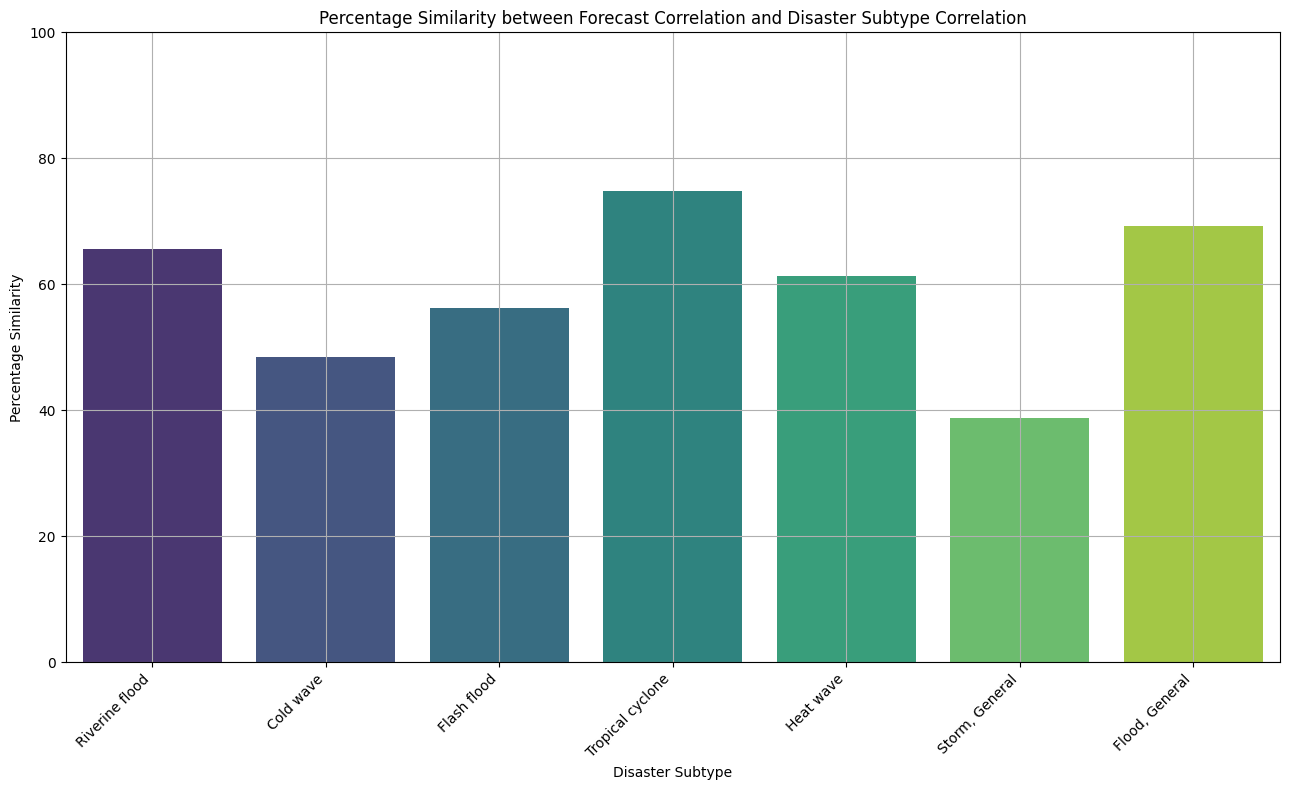

In [89]:
# Function to calculate the percentage similarity between correlation matrices
def calculate_percentage_similarity(correlation_1, correlation_2):

    # Calculates the Pearson correlation coefficient between the two matrices
    coef_pearson, _ = pearsonr(correlation_1.flatten(), correlation_2.flatten())

    print("Coeficiente de Correlação de Pearson:", coef_pearson)


    # Converts the correlation coefficient to a percentage
    percentage_similarity = coef_pearson * 100

    return coef_pearson * 100

percentage_similarities = [calculate_percentage_similarity(np.array(correlation_matrix), np.array(forecast_corr)) for correlation_matrix in [rf_corr, cw_corr, ff_corr, tc_corr, hw_corr, sg_corr, fg_corr]]

generate_barplot(disaster_subtypes, percentage_similarities)

### Spearman Correlation Coefficient


Coeficiente de Correlação de Spearman: 0.5538756486611393
Coeficiente de Correlação de Spearman: 0.427239062521874
Coeficiente de Correlação de Spearman: 0.43392017131150784
Coeficiente de Correlação de Spearman: 0.6904128543627795
Coeficiente de Correlação de Spearman: 0.5030148656861863
Coeficiente de Correlação de Spearman: 0.32103513893798136
Coeficiente de Correlação de Spearman: 0.5420607928486152


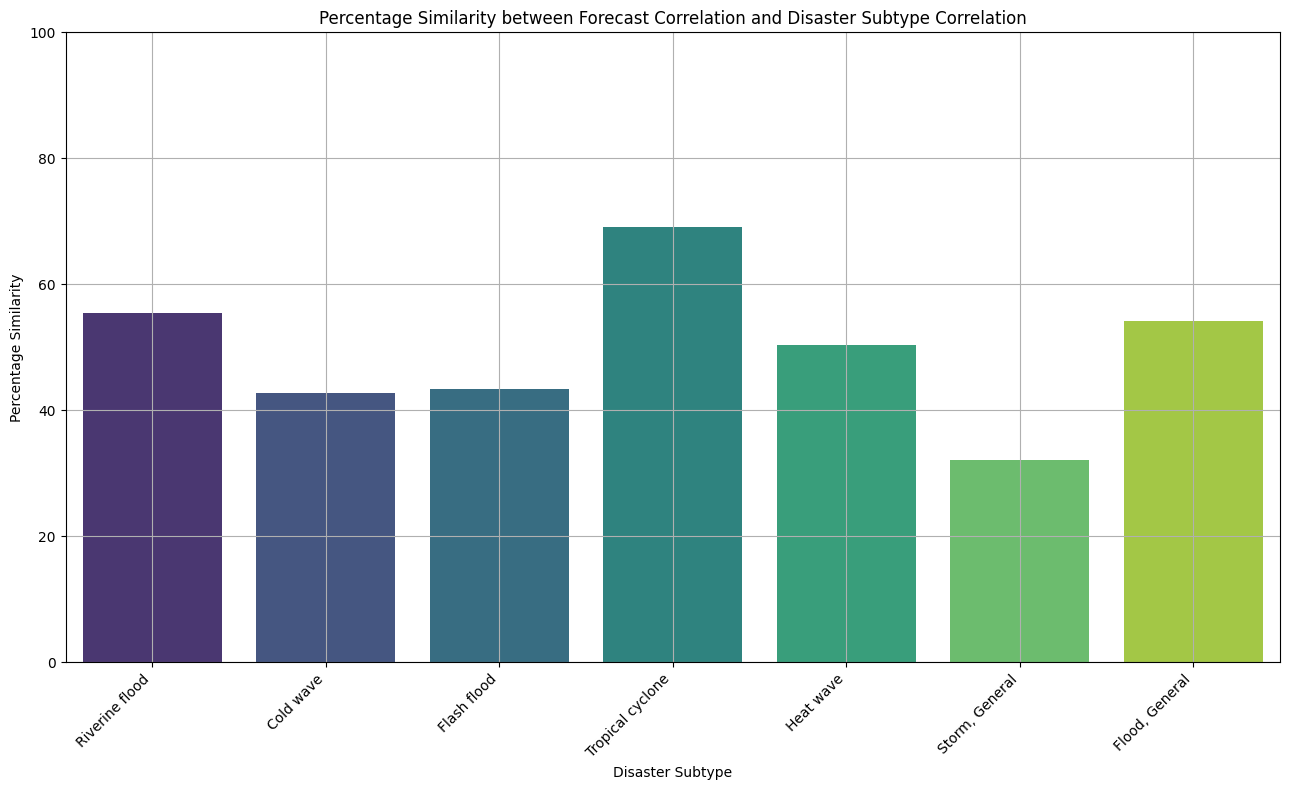

In [90]:
# Function to calculate the percentage similarity between correlation matrices
def calculate_percentage_similarity(correlation_1, correlation_2):

    # Calculates the Pearson correlation coefficient between the two matrices
    coef_spearman, _ = spearmanr(correlation_1.flatten(), correlation_2.flatten())

    print("Coeficiente de Correlação de Spearman:", coef_spearman)

    # Converts the correlation coefficient to a percentage
    percentage_similarity = coef_spearman * 100

    return coef_spearman * 100

percentage_similarities = [calculate_percentage_similarity(np.array(correlation_matrix), np.array(forecast_corr)) for correlation_matrix in [rf_corr, cw_corr, ff_corr, tc_corr, hw_corr, sg_corr, fg_corr]]

generate_barplot(disaster_subtypes, percentage_similarities)

### Kendall Correlation Coefficient


Coeficiente de Correlação de Kendall: 0.43140227825011296
Coeficiente de Correlação de Kendall: 0.3413932951445864
Coeficiente de Correlação de Kendall: 0.30731222387161994
Coeficiente de Correlação de Kendall: 0.5362671129361634
Coeficiente de Correlação de Kendall: 0.3979037893920691
Coeficiente de Correlação de Kendall: 0.24118911977791596
Coeficiente de Correlação de Kendall: 0.39178667403538275


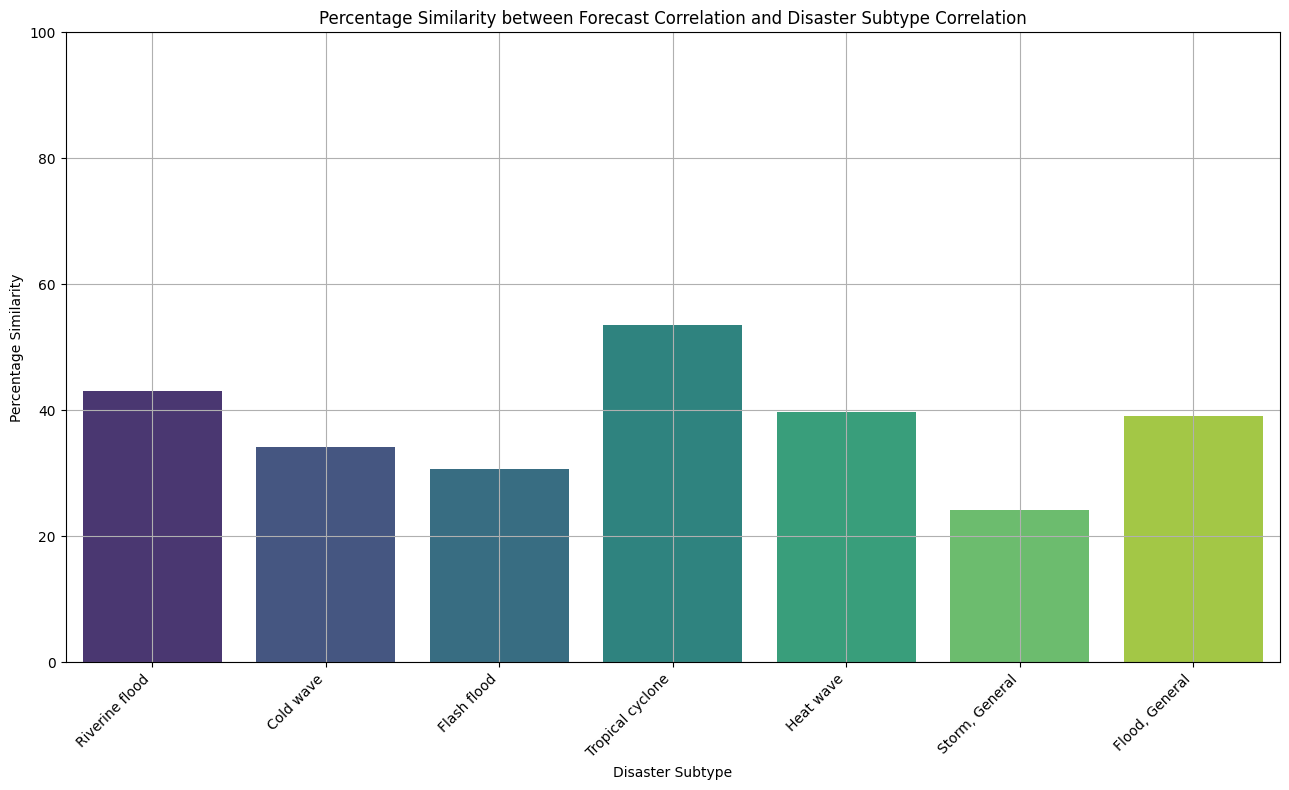

In [91]:
# Function to calculate the percentage similarity between correlation matrices
def calculate_percentage_similarity(correlation_1, correlation_2):

    # Calculates the Pearson correlation coefficient between the two matrices
    coef_kendall, _ = kendalltau(correlation_1.flatten(), correlation_2.flatten())

    print("Coeficiente de Correlação de Kendall:", coef_kendall)

    # Converts the correlation coefficient to a percentage
    percentage_similarity = coef_kendall * 100

    return coef_kendall * 100

percentage_similarities = [calculate_percentage_similarity(np.array(correlation_matrix), np.array(forecast_corr)) for correlation_matrix in [rf_corr, cw_corr, ff_corr, tc_corr, hw_corr, sg_corr, fg_corr]]

generate_barplot(disaster_subtypes, percentage_similarities)

# FIREBASE - FIRESTORE

### Recordings

In [ ]:
display(df)

date             id  disaster_subtype_code  \
0    2000-01-01 03:00:00  2000-0019-BRA                      0   
0    2000-01-02 03:00:00  2000-0019-BRA                      0   
0    2000-01-03 03:00:00  2000-0019-BRA                      0   
0    2000-01-04 03:00:00  2000-0019-BRA                      0   
0    2000-01-05 03:00:00  2000-0019-BRA                      0   
..                   ...            ...                    ...   
360  2023-11-15 03:00:00  2023-0777-BRA                      6   
360  2023-11-16 03:00:00  2023-0777-BRA                      6   
360  2023-11-17 03:00:00  2023-0777-BRA                      6   
360  2023-11-18 03:00:00  2023-0777-BRA                      6   
360  2023-11-19 03:00:00  2023-0777-BRA                      6   

    disaster_subtype country      continent  \
0     Riverine flood  Brazil  South America   
0     Riverine flood  Brazil  South America   
0     Riverine flood  Brazil  South America   
0     Riverine flood  Brazil  South America   
0     Riverine flood  Brazil  South America   
..               ...     ...            ...   
360   Flood, General  Brazil  South America   
360   Flood, General  Brazil  South America   
360   Flood, General  Brazil  South America   
360   Flood, General  Brazil  South America   
360   Flood, General  Brazil  South America   

                                             formatted             latitude  \
0    Rio de Janeiro, Região Metropolitana do Rio de...   -22.88224983215332   
0    Rio de Janeiro, Região Metropolitana do Rio de...   -22.88224983215332   
0    Rio de Janeiro, Região Metropolitana do Rio de...   -22.88224983215332   
0    Rio de Janeiro, Região Metropolitana do Rio de...   -22.88224983215332   
0    Rio de Janeiro, Região Metropolitana do Rio de...   -22.88224983215332   
..                                                 ...                  ...   
360  Taquari, Região Geográfica Intermediária de Sa...  -29.771530151367188   
360  Taquari, Região Geográfica Intermediária de Sa...  -29.771530151367188   
360  Taquari, Região Geográfica Intermediária de Sa...  -29.771530151367188   
360  Taquari, Região Geográfica Intermediária de Sa...  -29.771530151367188   
360  Taquari, Região Geográfica Intermediária de Sa...  -29.771530151367188   

              longitude  temperature_2m_max  ...  apparent_temperature_min  \
0    -43.07611083984375           28.136499  ...                 27.435997   
0    -43.07611083984375           27.436499  ...                 26.685484   
0    -43.07611083984375           27.836500  ...                 25.922243   
0    -43.07611083984375           32.286503  ...                 26.881165   
0    -43.07611083984375           33.186501  ...                 26.335186   
..                  ...                 ...  ...                       ...   
360      -51.8466796875           28.215500  ...                 18.984413   
360      -51.8466796875           25.315500  ...                 22.832615   
360      -51.8466796875           24.815500  ...                 18.749744   
360      -51.8466796875           25.165501  ...                 20.004423   
360      -51.8466796875           25.265501  ...                 16.594753   

     precipitation_sum   rain_sum  snowfall_sum  precipitation_hours  \
0            15.400001  15.400001           0.0                 17.0   
0            69.500000  69.500000           0.0                 22.0   
0            28.199997  28.199997           0.0                 18.0   
0             0.000000   0.000000           0.0                  0.0   
0             0.100000   0.100000           0.0                  1.0   
..                 ...        ...           ...                  ...   
360          29.100002  29.100002           0.0                 10.0   
360           8.200000   8.200000           0.0                 12.0   
360          66.599991  66.599991           0.0                 12.0   
360          16.400000  16.400000           0.0         

In [ ]:
from firebase_admin import firestore

_app = firebase_admin.get_app(name="pandora-400014")
if not _app:
 cred = credentials.Certificate(f"{userdata.get('notebook_path')}/{userdata.get('firestore_token_path')}.json")
 _app = firebase_admin.initialize_app(cred, name="pandora-400014")

db = firestore.client(app=_app)

In [ ]:
from datetime import datetime
from google.cloud import firestore

# Iterate over each row in the DataFrame and retrieve weather information
for i, infos in df.iterrows():
    # Call the search_info_weather function to retrieve weather information
    data = {
        #"id": infos['id'],
        #"date_occurred": infos['date'],
        #"timestamp": datetime.now(),
        #"position": firestore.GeoPoint(float(infos['latitude']), float(infos['longitude'])),
        #"address": infos['formatted'],
        # ===================================================================
        #"weather_data": {
        #    "apparent_temperature_max": infos['apparent_temperature_max'],
        #    "apparent_temperature_min": infos['apparent_temperature_min'],
        #    "et0_fao_evapotranspiration": infos['et0_fao_evapotranspiration'],
        #    "precipitation_hours": infos['precipitation_hours'],
        #    "precipitation_sum": infos['precipitation_sum'],
        #    "rain_sum": infos['rain_sum'],
        #    "shortwave_radiation_sum": infos['shortwave_radiation_sum'],
        #    "snowfall_sum": infos['snowfall_sum'],
        #    "temperature_2m_max": infos['temperature_2m_max'],
        #    "temperature_2m_min": infos['temperature_2m_min'],
        #    "wind_direction_10m_dominant": infos['wind_direction_10m_dominant'],
        #    "wind_gusts_10m_max": infos['wind_gusts_10m_max'],
        #    "wind_speed_10m_max": infos['wind_speed_10m_max'],
        #},
       }

    #db.collection("Extreme Event").document(infos['continent']).collection(infos['country']).document(infos['disaster_subtype']).collection("Location Data").document(", ".join([infos['latitude'], infos['longitude']])).collection("Weather Data").document().set(data)
    #db.collection("Extreme Event").document(infos['continent']).collection(infos['country']).document(infos['disaster_subtype']).collection("Location Data").document(", ".join([infos['latitude'], infos['longitude']])).set(data)

In [ ]:
#data = rf_corr["temperature_2m_max"].to_dict()
#print(data)
#data = {
#    "temperature_2m_max": cw_corr["temperature_2m_max"].to_dict(),
#    "temperature_2m_min": cw_corr["temperature_2m_min"].to_dict(),
#    "apparent_temperature_max": cw_corr["apparent_temperature_max"].to_dict(),
#    "apparent_temperature_min": cw_corr["apparent_temperature_min"].to_dict(),
#    "precipitation_sum": cw_corr["precipitation_sum"].to_dict(),
#    "rain_sum": cw_corr["rain_sum"].to_dict(),
#    "snowfall_sum": cw_corr["snowfall_sum"].to_dict(),
#    "precipitation_hours": cw_corr["precipitation_hours"].to_dict(),
#    "wind_gusts_10m_max": cw_corr["wind_gusts_10m_max"].to_dict(),
#    "wind_speed_10m_max": cw_corr["wind_speed_10m_max"].to_dict(),
#    "wind_direction_10m_dominant": cw_corr["wind_direction_10m_dominant"].to_dict(),
#    "shortwave_radiation_sum": cw_corr["shortwave_radiation_sum"].to_dict(),
#    "et0_fao_evapotranspiration": cw_corr["et0_fao_evapotranspiration"].to_dict()
#}
#
#db.collection("Extreme Event").document("South America").collection("Brazil").document("Cold wave").collection("Statistical Correlation Data").document().set(data)

{'temperature_2m_max': 1.0, 'temperature_2m_min': 0.5605479313943926, 'apparent_temperature_max': 0.930539014948474, 'apparent_temperature_min': 0.5922676621012464, 'precipitation_sum': -0.43203123277928646, 'rain_sum': -0.43203123277928646, 'snowfall_sum': 0.0, 'precipitation_hours': -0.5707927541479835, 'wind_speed_10m_max': -0.3187137300195557, 'wind_gusts_10m_max': -0.17834708986569095, 'wind_direction_10m_dominant': -0.1990609881309083, 'shortwave_radiation_sum': 0.6086715500416712, 'et0_fao_evapotranspiration': 0.6539375641750268}


update_time {
  seconds: 1711293590
  nanos: 915463000
}

In [ ]:
#response = []
#
#extreme_event_ref = db.collection("Extreme Event").document("South America").collection("Brazil")
#
#for doc in extreme_event_ref.stream():
#    max_records = 0
#    subtotal_records = 0
#    total_location_records = 0
#    total_recurrence = 0
#    max_sub_data = None
#    weather_data = []
#
#    for sub_doc in doc.reference.collection("Location Data").stream():
#        for sub_sub_doc in sub_doc.reference.collection("Weather Data").stream():
#            subtotal_records += 1
#            weather_data.append(sub_sub_doc.get('weather_data'))
#        total_recurrence += subtotal_records
#        total_location_records += 1
#        sub_data = {
#            "address" : sub_doc.get('address'),
#            "state" : sub_doc.get('state'),
#            "region" : sub_doc.get('region'),
#            "subtotal_records": subtotal_records
#        }
#        if subtotal_records > max_records:
#            max_records = subtotal_records
#            max_sub_data = sub_data
#
#
#    if max_sub_data:
#        data["site_greatest_recurrence"] = {
#            "address": max_sub_data["address"],
#            "state": max_sub_data["state"],
#            "region": max_sub_data["region"],
#            "subtotal_records": max_sub_data["subtotal_records"]
#        }
#
#    data["total_location_records"] = total_location_records
#    data["total_recurrence"] = total_recurrence
#    data["medium_duration"] = total_recurrence/total_location_records
#    data = {
#        "mean": pd.DataFrame(weather_data).mean().to_dict()
#    }
#
#    response.append(data)

#   db.collection("Extreme Event").document("South America").collection("Brazil").document(data['description']).set(data)
#    db.collection("Extreme Event").document("South America").collection("Brazil").document(doc.id).collection("Central Measurement Data").document().set(data)


### Readings


In [ ]:
# GET LOCALIZATION

from google.cloud.firestore import GeoPoint

_dict = []

extreme_event_ref = db.collection("Extreme Event").document("South America")

collections = extreme_event_ref.collections()
for collection in collections:
    for doc in collection.stream():
        docs = extreme_event_ref.collection("Brazil").document(doc.id).collection("Location Data").stream()
        for doc in docs:
            _dict.append([doc.to_dict().get('position').latitude, doc.to_dict().get('position').longitude])


df_tst = pd.DataFrame(_dict, columns=['Latitude', 'Longitude'])
display(df_tst)
display(len(df_tst))

Latitude  Longitude
0   -30.052725 -51.353546
1   -22.038664 -42.729156
2   -22.179262 -42.352936
3   -22.249561 -42.396698
4   -22.249561 -42.489655
..         ...        ...
302 -28.927944 -49.484528
303 -29.138840 -51.827576
304 -29.279438 -51.946991
305 -29.349737 -49.826996
306 -29.490334 -52.023132

[307 rows x 2 columns]

307